In [1]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import math

Importing plotly failed. Interactive plots will not work.


In [3]:
try:
    # Connect to an existing database
    connection = psycopg2.connect(database="2022-everything-team12", 
                            user='ycm3076', 
                            password='C13655814908y!', 
                            host='pg.analytics.northwestern.edu', 
                            port= '5432')

    # Create a cursor to perform database operations
    cursor = connection.cursor()
    # Print PostgreSQL details
    cursor.execute("SELECT version();")
    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)
df = pd.read_sql("select * from \"aggtrnsactdaily2\"", connection);
if (connection):
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed") 


You are connected to -  ('PostgreSQL 10.12 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-39), 64-bit',) 

PostgreSQL connection is closed


## Construct Dataset

In [4]:
df.tail()

,saledate,nstores,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,...,maxdiscount,totalprofit,avgprofittrnsact,minprofit,maxprofit,nstore,ncities,ndept,nvendors,avgvendorsstore
384,2005-08-26,324,144548,482390,525,19215591.82,20932.017233,0.0,1200.0,8968694.40,...,490.88,2344460.0,2553.876089,0.0,450.00,324,263,60,1056,3
385,2005-08-27,325,174635,726056,790,29404178.67,31995.841861,0.0,1200.0,14044552.29,...,540.00,3903930.0,4248.019859,0.0,555.29,325,264,60,1098,3
386,2005-02-23,324,154375,818303,739,36239176.72,32736.383668,0.0,1298.0,10507344.52,...,843.70,0.0,0.000000,0.0,780.00,324,263,58,1035,3
387,2005-02-24,324,155570,839153,735,35454568.88,31073.241788,0.0,1200.0,10844948.29,...,596.25,0.0,0.000000,0.0,495.00,324,263,58,1059,3
388,2005-02-25,324,163112,892854,774,37062627.79,32144.516730,0.0,1200.0,12367866.48,...,521.25,0.0,0.000000,0.0,500.00,324,263,58,1088,3


In [5]:
# check the data
df = df.sort_values(by=['saledate'])
df.tail()

,saledate,nstores,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,...,maxdiscount,totalprofit,avgprofittrnsact,minprofit,maxprofit,nstore,ncities,ndept,nvendors,avgvendorsstore
381,2005-08-23,325,84999,216712,226,7457004.46,7800.213870,0.0,1200.0,5141321.76,...,347.50,1477840.0,1545.861402,0.0,768.75,325,264,60,944,2
382,2005-08-24,325,140901,466006,496,19248987.11,20521.308220,0.0,1200.0,8398192.33,...,476.00,1982620.0,2113.670176,0.0,555.29,325,264,60,1041,3
383,2005-08-25,325,134977,422296,442,17062480.18,17885.199350,0.0,1200.0,7772270.13,...,581.75,1943150.0,2036.842243,0.0,500.00,325,264,60,1019,3
384,2005-08-26,324,144548,482390,525,19215591.82,20932.017233,0.0,1200.0,8968694.40,...,490.88,2344460.0,2553.876089,0.0,450.00,324,263,60,1056,3
385,2005-08-27,325,174635,726056,790,29404178.67,31995.841861,0.0,1200.0,14044552.29,...,540.00,3903930.0,4248.019859,0.0,555.29,325,264,60,1098,3


In [6]:
df.columns

Index(['saledate', 'nstores', 'nsku', 'totalquantity', 'avgquantity',
       'totalamt', 'avgamt', 'minamt', 'maxamt', 'totalorigprice',
       'avgorigprice', 'minorigprice', 'maxorigprice', 'totalretail',
       'avgretail', 'minretail', 'maxretail', 'avgretailtrnsact', 'totalcost',
       'avgcost', 'mincost', 'maxcost', 'avgcosttrnsact', 'totaldiscount',
       'avgdiscounttrnsact', 'mindiscount', 'maxdiscount', 'totalprofit',
       'avgprofittrnsact', 'minprofit', 'maxprofit', 'nstore', 'ncities',
       'ndept', 'nvendors', 'avgvendorsstore'],
      dtype='object')

In [7]:
# check null value counts
df.notnull().sum()

saledate              389
nstores               389
nsku                  389
totalquantity         389
avgquantity           389
totalamt              389
avgamt                389
minamt                389
maxamt                389
totalorigprice        389
avgorigprice          389
minorigprice          389
maxorigprice          389
totalretail           389
avgretail             389
minretail             389
maxretail             389
avgretailtrnsact      389
totalcost             389
avgcost               389
mincost               389
maxcost               389
avgcosttrnsact        389
totaldiscount         389
avgdiscounttrnsact    389
mindiscount           389
maxdiscount           389
totalprofit           389
avgprofittrnsact      389
minprofit             389
maxprofit             389
nstore                389
ncities               389
ndept                 389
nvendors              389
avgvendorsstore       389
dtype: int64

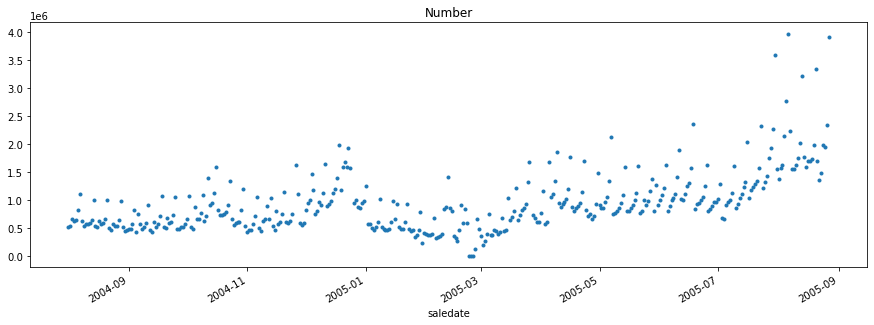

In [8]:
df_groupyed = df
color_pal = sns.color_palette()
# set df index as date
df_ts = df_groupyed.set_index('saledate')
df_ts.index = pd.to_datetime(df_ts.index)
# check distribution of amount (no pattern found)
df_ts_draw = df_ts["totalprofit"]
df_ts_draw.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Number')
plt.show()

In [19]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    return df
# create time series features
df_ts = create_features(df_ts)
df_ts

,nstores,nsku,totalquantity,avgquantity,totalamt,avgamt,minamt,maxamt,totalorigprice,avgorigprice,...,nstore,ncities,ndept,nvendors,avgvendorsstore,dayofweek,quarter,month,year,dayofmonth
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,323,61741,188073,783,6035654.36,25148.559833,0.0,895.0,4467905.60,23.756231,...,323,262,58,852,2,6,3,8,2004,1
2004-08-02,324,59183,177143,208,5637192.49,6624.197991,0.0,1200.0,4174584.51,23.566184,...,324,263,58,827,2,0,3,8,2004,2
2004-08-03,324,62593,212625,233,6569613.74,7219.355758,0.0,895.0,4833202.76,22.731112,...,324,263,58,842,2,1,3,8,2004,3
2004-08-04,324,65689,218053,241,6874637.33,7604.687312,0.0,895.0,4974026.91,22.811091,...,324,263,58,843,2,2,3,8,2004,4
2004-08-05,325,68941,225237,289,7913489.50,10184.671171,0.0,1200.0,5501540.60,24.425563,...,325,263,58,870,2,3,3,8,2004,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,325,84999,216712,226,7457004.46,7800.213870,0.0,1200.0,5141321.76,23.724214,...,325,264,60,944,2,1,3,8,2005,23
2005-08-24,325,140901,466006,496,19248987.11,20521.308220,0.0,1200.0,8398192.33,18.021640,...,325,264,60,1041,3,2,3,8,2005,24
2005-08-25,325,134977,422296,442,17062480.18,17885.199350,0.0,1200.0,7772270.13,18.404792,...,325,264,60,1019,3,3,3,8,2005,25


In [20]:
orignal_features = list(df.columns)
orignal_features.remove('saledate')
orignal_features

['nstores',
 'nsku',
 'totalquantity',
 'avgquantity',
 'totalamt',
 'avgamt',
 'minamt',
 'maxamt',
 'totalorigprice',
 'avgorigprice',
 'minorigprice',
 'maxorigprice',
 'totalretail',
 'avgretail',
 'minretail',
 'maxretail',
 'avgretailtrnsact',
 'totalcost',
 'avgcost',
 'mincost',
 'maxcost',
 'avgcosttrnsact',
 'totaldiscount',
 'avgdiscounttrnsact',
 'mindiscount',
 'maxdiscount',
 'totalprofit',
 'avgprofittrnsact',
 'minprofit',
 'maxprofit',
 'nstore',
 'ncities',
 'ndept',
 'nvendors',
 'avgvendorsstore']

In [21]:
# TODO: add lags
def create_lag_feature(df, column):
    '''
    Create time lagging features
    '''
    df = df.copy()
    average_value = np.mean(df[column])
    df[column + '_1'] = df[column].shift(1,fill_value = average_value)
    df[column + '_2'] = df[column].shift(2,fill_value = average_value)
    df[column + '_3'] = df[column].shift(3,fill_value = average_value)
    df[column + '_4'] = df[column].shift(4,fill_value = average_value)
    df[column + '_5'] = df[column].shift(5,fill_value = average_value)
    df[column + '_6'] = df[column].shift(6,fill_value = average_value)
    df[column + '_7'] = df[column].shift(7,fill_value = average_value)
    df[column + '_14'] = df[column].shift(14,fill_value = average_value)
    df[column + '_28'] = df[column].shift(28,fill_value = average_value)
    return df

df_model = df_ts
for col in orignal_features:
    df_model = create_lag_feature(df_model, col)

orignal_features1 = orignal_features.copy()
orignal_features1.remove('totalprofit')
df_ts_lagged = df_model.drop(orignal_features1, axis=1)
df_ts_lagged

,totalprofit,dayofweek,quarter,month,year,dayofmonth,nstores_1,nstores_2,nstores_3,nstores_4,...,nvendors_28,avgvendorsstore_1,avgvendorsstore_2,avgvendorsstore_3,avgvendorsstore_4,avgvendorsstore_5,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,511060.0,6,3,8,2004,1,323.701799,323.701799,323.701799,323.701799,...,931.768638,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-02,532033.0,0,3,8,2004,2,323.000000,323.701799,323.701799,323.701799,...,931.768638,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-03,659895.0,1,3,8,2004,3,324.000000,323.000000,323.701799,323.701799,...,931.768638,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-04,631430.0,2,3,8,2004,4,324.000000,324.000000,323.000000,323.701799,...,931.768638,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-05,635209.0,3,3,8,2004,5,324.000000,324.000000,324.000000,323.000000,...,931.768638,2.000000,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,1477840.0,1,3,8,2005,23,325.000000,325.000000,325.000000,325.000000,...,968.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000
2005-08-24,1982620.0,2,3,8,2005,24,325.000000,325.000000,325.000000,325.000000,...,1073.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000
2005-08-25,1943150.0,3,3,8,2005,25,325.000000,325.000000,325.000000,325.000000,...,1069.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000


In [22]:
df_ts_lagged.columns

Index(['totalprofit', 'dayofweek', 'quarter', 'month', 'year', 'dayofmonth',
       'nstores_1', 'nstores_2', 'nstores_3', 'nstores_4',
       ...
       'nvendors_28', 'avgvendorsstore_1', 'avgvendorsstore_2',
       'avgvendorsstore_3', 'avgvendorsstore_4', 'avgvendorsstore_5',
       'avgvendorsstore_6', 'avgvendorsstore_7', 'avgvendorsstore_14',
       'avgvendorsstore_28'],
      dtype='object', length=321)

In [23]:
df_total = df_ts_lagged.copy()
df_total['totalprofit'] = np.log(df_total['totalprofit']+1)
df_total.fillna(0,inplace = True)
df_total

,totalprofit,dayofweek,quarter,month,year,dayofmonth,nstores_1,nstores_2,nstores_3,nstores_4,...,nvendors_28,avgvendorsstore_1,avgvendorsstore_2,avgvendorsstore_3,avgvendorsstore_4,avgvendorsstore_5,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28
saledate,,,,,,,,,,,,,,,,,,,,,
2004-08-01,13.144244,6,3,8,2004,1,323.701799,323.701799,323.701799,323.701799,...,931.768638,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-02,13.184463,0,3,8,2004,2,323.000000,323.701799,323.701799,323.701799,...,931.768638,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-03,13.399838,1,3,8,2004,3,324.000000,323.000000,323.701799,323.701799,...,931.768638,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-04,13.355744,2,3,8,2004,4,324.000000,324.000000,323.000000,323.701799,...,931.768638,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2004-08-05,13.361711,3,3,8,2004,5,324.000000,324.000000,324.000000,323.000000,...,931.768638,2.000000,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-23,14.206093,1,3,8,2005,23,325.000000,325.000000,325.000000,325.000000,...,968.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000
2005-08-24,14.499930,2,3,8,2005,24,325.000000,325.000000,325.000000,325.000000,...,1073.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000
2005-08-25,14.479821,3,3,8,2005,25,325.000000,325.000000,325.000000,325.000000,...,1069.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000


In [24]:
df_total.notnull().sum()

totalprofit           389
dayofweek             389
quarter               389
month                 389
year                  389
                     ... 
avgvendorsstore_5     389
avgvendorsstore_6     389
avgvendorsstore_7     389
avgvendorsstore_14    389
avgvendorsstore_28    389
Length: 321, dtype: int64

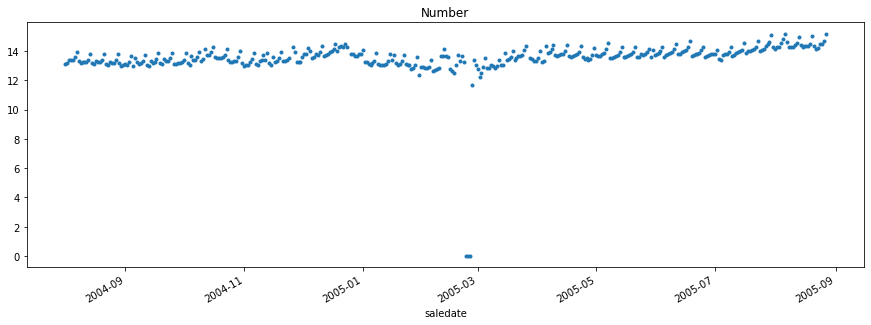

In [25]:
df_total['totalprofit'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Number')
plt.show()

## Prophet Modeling

In [26]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
import sklearn.metrics as metrics
import itertools

### Dataset Construction

In [34]:
df_state = df_total.copy()
df_state = df_state.reset_index()
df_state = df_state.rename(columns = {'saledate':'ds','totalprofit':'y'})
df_state

,ds,y,dayofweek,quarter,month,year,dayofmonth,nstores_1,nstores_2,nstores_3,...,nvendors_28,avgvendorsstore_1,avgvendorsstore_2,avgvendorsstore_3,avgvendorsstore_4,avgvendorsstore_5,avgvendorsstore_6,avgvendorsstore_7,avgvendorsstore_14,avgvendorsstore_28
0,2004-08-01,13.144244,6,3,8,2004,1,323.701799,323.701799,323.701799,...,931.768638,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
1,2004-08-02,13.184463,0,3,8,2004,2,323.000000,323.701799,323.701799,...,931.768638,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
2,2004-08-03,13.399838,1,3,8,2004,3,324.000000,323.000000,323.701799,...,931.768638,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
3,2004-08-04,13.355744,2,3,8,2004,4,324.000000,324.000000,323.000000,...,931.768638,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933,2.233933
4,2004-08-05,13.361711,3,3,8,2004,5,324.000000,324.000000,324.000000,...,931.768638,2.000000,2.000000,2.000000,2.000000,2.233933,2.233933,2.233933,2.233933,2.233933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,2005-08-23,14.206093,1,3,8,2005,23,325.000000,325.000000,325.000000,...,968.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000
385,2005-08-24,14.499930,2,3,8,2005,24,325.000000,325.000000,325.000000,...,1073.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000
386,2005-08-25,14.479821,3,3,8,2005,25,325.000000,325.000000,325.000000,...,1069.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,3.000000
387,2005-08-26,14.667566,4,3,8,2005,26,325.000000,325.000000,325.000000,...,1054.000000,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000


### train/test split

In [35]:
df_train = df_state[df_state['ds']<='2005-05-31']
df_test = df_state[df_state['ds']>'2005-05-31']

In [36]:
df_train.columns

Index(['ds', 'y', 'dayofweek', 'quarter', 'month', 'year', 'dayofmonth',
       'nstores_1', 'nstores_2', 'nstores_3',
       ...
       'nvendors_28', 'avgvendorsstore_1', 'avgvendorsstore_2',
       'avgvendorsstore_3', 'avgvendorsstore_4', 'avgvendorsstore_5',
       'avgvendorsstore_6', 'avgvendorsstore_7', 'avgvendorsstore_14',
       'avgvendorsstore_28'],
      dtype='object', length=322)

### Adding holidays, seasonality and additional features

In [37]:
lag1_features = [each + "_1" for each in orignal_features]
lag1_features

['nstores_1',
 'nsku_1',
 'totalquantity_1',
 'avgquantity_1',
 'totalamt_1',
 'avgamt_1',
 'minamt_1',
 'maxamt_1',
 'totalorigprice_1',
 'avgorigprice_1',
 'minorigprice_1',
 'maxorigprice_1',
 'totalretail_1',
 'avgretail_1',
 'minretail_1',
 'maxretail_1',
 'avgretailtrnsact_1',
 'totalcost_1',
 'avgcost_1',
 'mincost_1',
 'maxcost_1',
 'avgcosttrnsact_1',
 'totaldiscount_1',
 'avgdiscounttrnsact_1',
 'mindiscount_1',
 'maxdiscount_1',
 'totalprofit_1',
 'avgprofittrnsact_1',
 'minprofit_1',
 'maxprofit_1',
 'nstore_1',
 'ncities_1',
 'ndept_1',
 'nvendors_1',
 'avgvendorsstore_1']

In [38]:
df_train_part = df_train[lag1_features]
df_train_part['y'] = df_train['y']
df_train_part.corr()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nstores_1,nsku_1,totalquantity_1,avgquantity_1,totalamt_1,avgamt_1,minamt_1,maxamt_1,totalorigprice_1,avgorigprice_1,...,totalprofit_1,avgprofittrnsact_1,minprofit_1,maxprofit_1,nstore_1,ncities_1,ndept_1,nvendors_1,avgvendorsstore_1,y
nstores_1,1.000000,0.055186,0.004705,-0.148440,-0.009854,-0.151775,NaN,0.008181,0.102500,0.269496,...,0.145522,-0.020581,NaN,0.138019,1.000000,0.986730,0.156067,0.192565,0.053648,0.028746
nsku_1,0.055186,1.000000,0.894138,0.488733,0.914481,0.553821,NaN,0.107719,0.816460,-0.332144,...,0.326006,0.064139,NaN,0.141148,0.055186,0.051852,0.115127,0.916194,0.743830,-0.185123
totalquantity_1,0.004705,0.894138,1.000000,0.491492,0.982145,0.528415,NaN,0.068057,0.880089,-0.391341,...,0.386390,0.056911,NaN,0.034617,0.004705,-0.013065,-0.005539,0.813667,0.726200,-0.212607
avgquantity_1,-0.148440,0.488733,0.491492,1.000000,0.502931,0.984195,NaN,0.044305,0.409696,-0.273018,...,0.114727,0.694678,NaN,0.029332,-0.148440,-0.154798,-0.042723,0.373409,0.306333,-0.120772
totalamt_1,-0.009854,0.914481,0.982145,0.502931,1.000000,0.565743,NaN,0.091277,0.819632,-0.434897,...,0.258677,0.003331,NaN,0.060047,-0.009854,-0.021254,-0.016299,0.815704,0.717549,-0.274732
avgamt_1,-0.151775,0.553821,0.528415,0.984195,0.565743,1.000000,NaN,0.066178,0.413092,-0.324594,...,0.048039,0.600573,NaN,0.051829,-0.151775,-0.154600,-0.053731,0.427067,0.338424,-0.166363
minamt_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
maxamt_1,0.008181,0.107719,0.068057,0.044305,0.091277,0.066178,NaN,1.000000,0.048866,0.002601,...,-0.000599,-0.011170,NaN,0.800085,0.008181,0.003178,0.110636,0.124637,0.057635,-0.035271
totalorigprice_1,0.102500,0.816460,0.880089,0.409696,0.819632,0.413092,NaN,0.048866,1.000000,0.019255,...,0.706486,0.240001,NaN,0.032668,0.102500,0.101506,0.054560,0.813445,0.742865,0.027677
avgorigprice_1,0.269496,-0.332144,-0.391341,-0.273018,-0.434897,-0.324594,NaN,0.002601,0.019255,1.000000,...,0.440160,0.312951,NaN,0.059032,0.269496,0.327651,0.263335,-0.141494,-0.118295,0.371958


In [87]:
dict_param = {  
    'changepoint_prior_scale': 0.5,
    'seasonality_prior_scale': 10.0,
    'holidays_prior_scale': 10.0,
    'changepoint_range':0.8
}

def modeling(df_train,dict_param):
    
    #add seasonality
    '''
        We drop the yearly seasonality since the training dataset is less than one year and we add quarterly, montly seasonality instead.
    '''
    m = Prophet(yearly_seasonality = False,growth = 'flat',**dict_param)
    #m.add_seasonality(name="quarterly", period=90, fourier_order = 10)
    m.add_seasonality(name='monthly', period=30, fourier_order=5) 

    #add holiday
    m.add_country_holidays(country_name='US')

    #add additional features
    feature_list = ['nsku',
                    'avgprofittrnsact',
                    'totalamt',
                    'avgorigprice',
                    'totalquantity']
    for feature in feature_list:
        m.add_regressor(feature+'_1',standardize = "auto")

    m.fit(df_train)
    
    return m

m = modeling(df_train,dict_param)

19:40:25 - cmdstanpy - INFO - Chain [1] start processing
19:40:25 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
#check the influence of regressors to y
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,nsku_1,additive,8.505259e+04,1.199974e-05,1.199974e-05,1.199974e-05
1,avgprofittrnsact_1,additive,1.097601e+03,2.159214e-04,2.159214e-04,2.159214e-04
2,totalamt_1,additive,1.015165e+07,-4.036037e-07,-4.036037e-07,-4.036037e-07
3,avgorigprice_1,additive,2.485654e+01,8.676001e-02,8.676001e-02,8.676001e-02
4,totalquantity_1,additive,2.831029e+05,1.257880e-05,1.257880e-05,1.257880e-05


### Model tuning

In [89]:
param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'holidays_prior_scale': [0.1, 1.0, 10.0],
        'changepoint_range':[0.8,1.0]
    }

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Store the RMSEs for each params here
mse = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = modeling(df_train,params) # Fit model with given params
    df_cv = cross_validation(m, initial = '200 days',period = '15 days',horizon = '15 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mse.append(df_p['mse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mse
print(tuning_results)
best_params = all_params[np.argmin(mse)]

19:40:27 - cmdstanpy - INFO - Chain [1] start processing
19:40:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:27 - cmdstanpy - INFO - Chain [1] start processing
19:40:27 - cmdstanpy - INFO - Chain [1] done processing
19:40:27 - cmdstanpy - INFO - Chain [1] start processing
19:40:28 - cmdstanpy - INFO - Chain [1] done processing
19:40:28 - cmdstanpy - INFO - Chain [1] start processing
19:40:28 - cmdstanpy - INFO - Chain [1] done processing
19:40:28 - cmdstanpy - INFO - Chain [1] start processing
19:40:28 - cmdstanpy - INFO - Chain [1] done processing
19:40:28 - cmdstanpy - INFO - Chain [1] start processing
19:40:29 - cmdstanpy - INFO - Chain [1] done processing
19:40:29 - cmdstanpy - INFO - Chain [1] start processing
19:40:29 - cmdstanpy - INFO - Chain [1] done processing
19:40:29 - cmdstanpy - INFO - Chain [1] start processing
19:40:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:29 - cmdstanpy - INFO - Chain [1] start processing
19:40:29 - cmdstanpy - INFO - Chain [1] done processing
19:40:30 - cmdstanpy - INFO - Chain [1] start processing
19:40:30 - cmdstanpy - INFO - Chain [1] done processing
19:40:30 - cmdstanpy - INFO - Chain [1] start processing
19:40:30 - cmdstanpy - INFO - Chain [1] done processing
19:40:30 - cmdstanpy - INFO - Chain [1] start processing
19:40:30 - cmdstanpy - INFO - Chain [1] done processing
19:40:31 - cmdstanpy - INFO - Chain [1] start processing
19:40:31 - cmdstanpy - INFO - Chain [1] done processing
19:40:31 - cmdstanpy - INFO - Chain [1] start processing
19:40:31 - cmdstanpy - INFO - Chain [1] done processing
19:40:31 - cmdstanpy - INFO - Chain [1] start processing
19:40:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:31 - cmdstanpy - INFO - Chain [1] start processing
19:40:32 - cmdstanpy - INFO - Chain [1] done processing
19:40:32 - cmdstanpy - INFO - Chain [1] start processing
19:40:32 - cmdstanpy - INFO - Chain [1] done processing
19:40:32 - cmdstanpy - INFO - Chain [1] start processing
19:40:32 - cmdstanpy - INFO - Chain [1] done processing
19:40:32 - cmdstanpy - INFO - Chain [1] start processing
19:40:33 - cmdstanpy - INFO - Chain [1] done processing
19:40:33 - cmdstanpy - INFO - Chain [1] start processing
19:40:33 - cmdstanpy - INFO - Chain [1] done processing
19:40:33 - cmdstanpy - INFO - Chain [1] start processing
19:40:33 - cmdstanpy - INFO - Chain [1] done processing
19:40:33 - cmdstanpy - INFO - Chain [1] start processing
19:40:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:34 - cmdstanpy - INFO - Chain [1] start processing
19:40:34 - cmdstanpy - INFO - Chain [1] done processing
19:40:34 - cmdstanpy - INFO - Chain [1] start processing
19:40:34 - cmdstanpy - INFO - Chain [1] done processing
19:40:34 - cmdstanpy - INFO - Chain [1] start processing
19:40:34 - cmdstanpy - INFO - Chain [1] done processing
19:40:34 - cmdstanpy - INFO - Chain [1] start processing
19:40:35 - cmdstanpy - INFO - Chain [1] done processing
19:40:35 - cmdstanpy - INFO - Chain [1] start processing
19:40:35 - cmdstanpy - INFO - Chain [1] done processing
19:40:35 - cmdstanpy - INFO - Chain [1] start processing
19:40:35 - cmdstanpy - INFO - Chain [1] done processing
19:40:36 - cmdstanpy - INFO - Chain [1] start processing
19:40:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:36 - cmdstanpy - INFO - Chain [1] start processing
19:40:36 - cmdstanpy - INFO - Chain [1] done processing
19:40:36 - cmdstanpy - INFO - Chain [1] start processing
19:40:36 - cmdstanpy - INFO - Chain [1] done processing
19:40:36 - cmdstanpy - INFO - Chain [1] start processing
19:40:36 - cmdstanpy - INFO - Chain [1] done processing
19:40:37 - cmdstanpy - INFO - Chain [1] start processing
19:40:37 - cmdstanpy - INFO - Chain [1] done processing
19:40:37 - cmdstanpy - INFO - Chain [1] start processing
19:40:37 - cmdstanpy - INFO - Chain [1] done processing
19:40:37 - cmdstanpy - INFO - Chain [1] start processing
19:40:37 - cmdstanpy - INFO - Chain [1] done processing
19:40:38 - cmdstanpy - INFO - Chain [1] start processing
19:40:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:38 - cmdstanpy - INFO - Chain [1] start processing
19:40:38 - cmdstanpy - INFO - Chain [1] done processing
19:40:38 - cmdstanpy - INFO - Chain [1] start processing
19:40:38 - cmdstanpy - INFO - Chain [1] done processing
19:40:38 - cmdstanpy - INFO - Chain [1] start processing
19:40:38 - cmdstanpy - INFO - Chain [1] done processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] done processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] done processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] done processing
19:40:40 - cmdstanpy - INFO - Chain [1] start processing
19:40:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:40 - cmdstanpy - INFO - Chain [1] start processing
19:40:40 - cmdstanpy - INFO - Chain [1] done processing
19:40:40 - cmdstanpy - INFO - Chain [1] start processing
19:40:40 - cmdstanpy - INFO - Chain [1] done processing
19:40:40 - cmdstanpy - INFO - Chain [1] start processing
19:40:41 - cmdstanpy - INFO - Chain [1] done processing
19:40:41 - cmdstanpy - INFO - Chain [1] start processing
19:40:41 - cmdstanpy - INFO - Chain [1] done processing
19:40:41 - cmdstanpy - INFO - Chain [1] start processing
19:40:41 - cmdstanpy - INFO - Chain [1] done processing
19:40:41 - cmdstanpy - INFO - Chain [1] start processing
19:40:41 - cmdstanpy - INFO - Chain [1] done processing
19:40:42 - cmdstanpy - INFO - Chain [1] start processing
19:40:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:42 - cmdstanpy - INFO - Chain [1] start processing
19:40:42 - cmdstanpy - INFO - Chain [1] done processing
19:40:42 - cmdstanpy - INFO - Chain [1] start processing
19:40:42 - cmdstanpy - INFO - Chain [1] done processing
19:40:43 - cmdstanpy - INFO - Chain [1] start processing
19:40:43 - cmdstanpy - INFO - Chain [1] done processing
19:40:43 - cmdstanpy - INFO - Chain [1] start processing
19:40:43 - cmdstanpy - INFO - Chain [1] done processing
19:40:43 - cmdstanpy - INFO - Chain [1] start processing
19:40:43 - cmdstanpy - INFO - Chain [1] done processing
19:40:44 - cmdstanpy - INFO - Chain [1] start processing
19:40:44 - cmdstanpy - INFO - Chain [1] done processing
19:40:44 - cmdstanpy - INFO - Chain [1] start processing
19:40:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:44 - cmdstanpy - INFO - Chain [1] start processing
19:40:44 - cmdstanpy - INFO - Chain [1] done processing
19:40:44 - cmdstanpy - INFO - Chain [1] start processing
19:40:44 - cmdstanpy - INFO - Chain [1] done processing
19:40:45 - cmdstanpy - INFO - Chain [1] start processing
19:40:45 - cmdstanpy - INFO - Chain [1] done processing
19:40:45 - cmdstanpy - INFO - Chain [1] start processing
19:40:45 - cmdstanpy - INFO - Chain [1] done processing
19:40:45 - cmdstanpy - INFO - Chain [1] start processing
19:40:45 - cmdstanpy - INFO - Chain [1] done processing
19:40:46 - cmdstanpy - INFO - Chain [1] start processing
19:40:46 - cmdstanpy - INFO - Chain [1] done processing
19:40:46 - cmdstanpy - INFO - Chain [1] start processing
19:40:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:46 - cmdstanpy - INFO - Chain [1] start processing
19:40:46 - cmdstanpy - INFO - Chain [1] done processing
19:40:46 - cmdstanpy - INFO - Chain [1] start processing
19:40:46 - cmdstanpy - INFO - Chain [1] done processing
19:40:47 - cmdstanpy - INFO - Chain [1] start processing
19:40:47 - cmdstanpy - INFO - Chain [1] done processing
19:40:47 - cmdstanpy - INFO - Chain [1] start processing
19:40:47 - cmdstanpy - INFO - Chain [1] done processing
19:40:47 - cmdstanpy - INFO - Chain [1] start processing
19:40:47 - cmdstanpy - INFO - Chain [1] done processing
19:40:48 - cmdstanpy - INFO - Chain [1] start processing
19:40:48 - cmdstanpy - INFO - Chain [1] done processing
19:40:48 - cmdstanpy - INFO - Chain [1] start processing
19:40:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:48 - cmdstanpy - INFO - Chain [1] start processing
19:40:48 - cmdstanpy - INFO - Chain [1] done processing
19:40:48 - cmdstanpy - INFO - Chain [1] start processing
19:40:49 - cmdstanpy - INFO - Chain [1] done processing
19:40:49 - cmdstanpy - INFO - Chain [1] start processing
19:40:49 - cmdstanpy - INFO - Chain [1] done processing
19:40:49 - cmdstanpy - INFO - Chain [1] start processing
19:40:49 - cmdstanpy - INFO - Chain [1] done processing
19:40:49 - cmdstanpy - INFO - Chain [1] start processing
19:40:49 - cmdstanpy - INFO - Chain [1] done processing
19:40:50 - cmdstanpy - INFO - Chain [1] start processing
19:40:50 - cmdstanpy - INFO - Chain [1] done processing
19:40:50 - cmdstanpy - INFO - Chain [1] start processing
19:40:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:50 - cmdstanpy - INFO - Chain [1] start processing
19:40:50 - cmdstanpy - INFO - Chain [1] done processing
19:40:50 - cmdstanpy - INFO - Chain [1] start processing
19:40:50 - cmdstanpy - INFO - Chain [1] done processing
19:40:51 - cmdstanpy - INFO - Chain [1] start processing
19:40:51 - cmdstanpy - INFO - Chain [1] done processing
19:40:51 - cmdstanpy - INFO - Chain [1] start processing
19:40:51 - cmdstanpy - INFO - Chain [1] done processing
19:40:51 - cmdstanpy - INFO - Chain [1] start processing
19:40:52 - cmdstanpy - INFO - Chain [1] done processing
19:40:52 - cmdstanpy - INFO - Chain [1] start processing
19:40:52 - cmdstanpy - INFO - Chain [1] done processing
19:40:52 - cmdstanpy - INFO - Chain [1] start processing
19:40:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:52 - cmdstanpy - INFO - Chain [1] start processing
19:40:52 - cmdstanpy - INFO - Chain [1] done processing
19:40:53 - cmdstanpy - INFO - Chain [1] start processing
19:40:53 - cmdstanpy - INFO - Chain [1] done processing
19:40:53 - cmdstanpy - INFO - Chain [1] start processing
19:40:53 - cmdstanpy - INFO - Chain [1] done processing
19:40:53 - cmdstanpy - INFO - Chain [1] start processing
19:40:53 - cmdstanpy - INFO - Chain [1] done processing
19:40:54 - cmdstanpy - INFO - Chain [1] start processing
19:40:54 - cmdstanpy - INFO - Chain [1] done processing
19:40:54 - cmdstanpy - INFO - Chain [1] start processing
19:40:54 - cmdstanpy - INFO - Chain [1] done processing
19:40:54 - cmdstanpy - INFO - Chain [1] start processing
19:40:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:54 - cmdstanpy - INFO - Chain [1] start processing
19:40:54 - cmdstanpy - INFO - Chain [1] done processing
19:40:55 - cmdstanpy - INFO - Chain [1] start processing
19:40:55 - cmdstanpy - INFO - Chain [1] done processing
19:40:55 - cmdstanpy - INFO - Chain [1] start processing
19:40:55 - cmdstanpy - INFO - Chain [1] done processing
19:40:55 - cmdstanpy - INFO - Chain [1] start processing
19:40:55 - cmdstanpy - INFO - Chain [1] done processing
19:40:56 - cmdstanpy - INFO - Chain [1] start processing
19:40:56 - cmdstanpy - INFO - Chain [1] done processing
19:40:56 - cmdstanpy - INFO - Chain [1] start processing
19:40:56 - cmdstanpy - INFO - Chain [1] done processing
19:40:56 - cmdstanpy - INFO - Chain [1] start processing
19:40:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:56 - cmdstanpy - INFO - Chain [1] start processing
19:40:56 - cmdstanpy - INFO - Chain [1] done processing
19:40:57 - cmdstanpy - INFO - Chain [1] start processing
19:40:57 - cmdstanpy - INFO - Chain [1] done processing
19:40:57 - cmdstanpy - INFO - Chain [1] start processing
19:40:57 - cmdstanpy - INFO - Chain [1] done processing
19:40:57 - cmdstanpy - INFO - Chain [1] start processing
19:40:57 - cmdstanpy - INFO - Chain [1] done processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] done processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] done processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] done processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] done processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] done processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] done processing
19:41:00 - cmdstanpy - INFO - Chain [1] start processing
19:41:00 - cmdstanpy - INFO - Chain [1] done processing
19:41:00 - cmdstanpy - INFO - Chain [1] start processing
19:41:00 - cmdstanpy - INFO - Chain [1] done processing
19:41:00 - cmdstanpy - INFO - Chain [1] start processing
19:41:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:01 - cmdstanpy - INFO - Chain [1] start processing
19:41:01 - cmdstanpy - INFO - Chain [1] done processing
19:41:01 - cmdstanpy - INFO - Chain [1] start processing
19:41:01 - cmdstanpy - INFO - Chain [1] done processing
19:41:01 - cmdstanpy - INFO - Chain [1] start processing
19:41:01 - cmdstanpy - INFO - Chain [1] done processing
19:41:02 - cmdstanpy - INFO - Chain [1] start processing
19:41:02 - cmdstanpy - INFO - Chain [1] done processing
19:41:02 - cmdstanpy - INFO - Chain [1] start processing
19:41:02 - cmdstanpy - INFO - Chain [1] done processing
19:41:02 - cmdstanpy - INFO - Chain [1] start processing
19:41:02 - cmdstanpy - INFO - Chain [1] done processing
19:41:03 - cmdstanpy - INFO - Chain [1] start processing
19:41:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:03 - cmdstanpy - INFO - Chain [1] start processing
19:41:03 - cmdstanpy - INFO - Chain [1] done processing
19:41:03 - cmdstanpy - INFO - Chain [1] start processing
19:41:03 - cmdstanpy - INFO - Chain [1] done processing
19:41:03 - cmdstanpy - INFO - Chain [1] start processing
19:41:03 - cmdstanpy - INFO - Chain [1] done processing
19:41:04 - cmdstanpy - INFO - Chain [1] start processing
19:41:04 - cmdstanpy - INFO - Chain [1] done processing
19:41:04 - cmdstanpy - INFO - Chain [1] start processing
19:41:04 - cmdstanpy - INFO - Chain [1] done processing
19:41:04 - cmdstanpy - INFO - Chain [1] start processing
19:41:04 - cmdstanpy - INFO - Chain [1] done processing
19:41:05 - cmdstanpy - INFO - Chain [1] start processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:05 - cmdstanpy - INFO - Chain [1] start processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing
19:41:05 - cmdstanpy - INFO - Chain [1] start processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing
19:41:05 - cmdstanpy - INFO - Chain [1] start processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing
19:41:06 - cmdstanpy - INFO - Chain [1] start processing
19:41:06 - cmdstanpy - INFO - Chain [1] done processing
19:41:06 - cmdstanpy - INFO - Chain [1] start processing
19:41:06 - cmdstanpy - INFO - Chain [1] done processing
19:41:06 - cmdstanpy - INFO - Chain [1] start processing
19:41:06 - cmdstanpy - INFO - Chain [1] done processing
19:41:07 - cmdstanpy - INFO - Chain [1] start processing
19:41:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:07 - cmdstanpy - INFO - Chain [1] start processing
19:41:07 - cmdstanpy - INFO - Chain [1] done processing
19:41:07 - cmdstanpy - INFO - Chain [1] start processing
19:41:07 - cmdstanpy - INFO - Chain [1] done processing
19:41:07 - cmdstanpy - INFO - Chain [1] start processing
19:41:07 - cmdstanpy - INFO - Chain [1] done processing
19:41:08 - cmdstanpy - INFO - Chain [1] start processing
19:41:08 - cmdstanpy - INFO - Chain [1] done processing
19:41:08 - cmdstanpy - INFO - Chain [1] start processing
19:41:08 - cmdstanpy - INFO - Chain [1] done processing
19:41:08 - cmdstanpy - INFO - Chain [1] start processing
19:41:08 - cmdstanpy - INFO - Chain [1] done processing
19:41:09 - cmdstanpy - INFO - Chain [1] start processing
19:41:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:09 - cmdstanpy - INFO - Chain [1] start processing
19:41:09 - cmdstanpy - INFO - Chain [1] done processing
19:41:09 - cmdstanpy - INFO - Chain [1] start processing
19:41:09 - cmdstanpy - INFO - Chain [1] done processing
19:41:10 - cmdstanpy - INFO - Chain [1] start processing
19:41:10 - cmdstanpy - INFO - Chain [1] done processing
19:41:10 - cmdstanpy - INFO - Chain [1] start processing
19:41:10 - cmdstanpy - INFO - Chain [1] done processing
19:41:10 - cmdstanpy - INFO - Chain [1] start processing
19:41:10 - cmdstanpy - INFO - Chain [1] done processing
19:41:11 - cmdstanpy - INFO - Chain [1] start processing
19:41:11 - cmdstanpy - INFO - Chain [1] done processing
19:41:11 - cmdstanpy - INFO - Chain [1] start processing
19:41:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:11 - cmdstanpy - INFO - Chain [1] start processing
19:41:11 - cmdstanpy - INFO - Chain [1] done processing
19:41:11 - cmdstanpy - INFO - Chain [1] start processing
19:41:11 - cmdstanpy - INFO - Chain [1] done processing
19:41:12 - cmdstanpy - INFO - Chain [1] start processing
19:41:12 - cmdstanpy - INFO - Chain [1] done processing
19:41:12 - cmdstanpy - INFO - Chain [1] start processing
19:41:12 - cmdstanpy - INFO - Chain [1] done processing
19:41:12 - cmdstanpy - INFO - Chain [1] start processing
19:41:12 - cmdstanpy - INFO - Chain [1] done processing
19:41:13 - cmdstanpy - INFO - Chain [1] start processing
19:41:13 - cmdstanpy - INFO - Chain [1] done processing
19:41:13 - cmdstanpy - INFO - Chain [1] start processing
19:41:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:13 - cmdstanpy - INFO - Chain [1] start processing
19:41:13 - cmdstanpy - INFO - Chain [1] done processing
19:41:14 - cmdstanpy - INFO - Chain [1] start processing
19:41:14 - cmdstanpy - INFO - Chain [1] done processing
19:41:14 - cmdstanpy - INFO - Chain [1] start processing
19:41:14 - cmdstanpy - INFO - Chain [1] done processing
19:41:14 - cmdstanpy - INFO - Chain [1] start processing
19:41:14 - cmdstanpy - INFO - Chain [1] done processing
19:41:14 - cmdstanpy - INFO - Chain [1] start processing
19:41:14 - cmdstanpy - INFO - Chain [1] done processing
19:41:15 - cmdstanpy - INFO - Chain [1] start processing
19:41:15 - cmdstanpy - INFO - Chain [1] done processing
19:41:15 - cmdstanpy - INFO - Chain [1] start processing
19:41:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:15 - cmdstanpy - INFO - Chain [1] start processing
19:41:15 - cmdstanpy - INFO - Chain [1] done processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] done processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] done processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] done processing
19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:17 - cmdstanpy - INFO - Chain [1] done processing
19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:17 - cmdstanpy - INFO - Chain [1] done processing
19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:17 - cmdstanpy - INFO - Chain [1] done processing
19:41:18 - cmdstanpy - INFO - Chain [1] start processing
19:41:18 - cmdstanpy - INFO - Chain [1] done processing
19:41:18 - cmdstanpy - INFO - Chain [1] start processing
19:41:18 - cmdstanpy - INFO - Chain [1] done processing
19:41:18 - cmdstanpy - INFO - Chain [1] start processing
19:41:18 - cmdstanpy - INFO - Chain [1] done processing
19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:19 - cmdstanpy - INFO - Chain [1] done processing
19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:19 - cmdstanpy - INFO - Chain [1] done processing
19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:20 - cmdstanpy - INFO - Chain [1] done processing
19:41:20 - cmdstanpy - INFO - Chain [1] start processing
19:41:20 - cmdstanpy - INFO - Chain [1] done processing
19:41:20 - cmdstanpy - INFO - Chain [1] start processing
19:41:20 - cmdstanpy - INFO - Chain [1] done processing
19:41:20 - cmdstanpy - INFO - Chain [1] start processing
19:41:20 - cmdstanpy - INFO - Chain [1] done processing
19:41:21 - cmdstanpy - INFO - Chain [1] start processing
19:41:21 - cmdstanpy - INFO - Chain [1] done processing
19:41:21 - cmdstanpy - INFO - Chain [1] start processing
19:41:21 - cmdstanpy - INFO - Chain [1] done processing
19:41:21 - cmdstanpy - INFO - Chain [1] start processing
19:41:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:22 - cmdstanpy - INFO - Chain [1] start processing
19:41:22 - cmdstanpy - INFO - Chain [1] done processing
19:41:22 - cmdstanpy - INFO - Chain [1] start processing
19:41:22 - cmdstanpy - INFO - Chain [1] done processing
19:41:22 - cmdstanpy - INFO - Chain [1] start processing
19:41:22 - cmdstanpy - INFO - Chain [1] done processing
19:41:22 - cmdstanpy - INFO - Chain [1] start processing
19:41:22 - cmdstanpy - INFO - Chain [1] done processing
19:41:23 - cmdstanpy - INFO - Chain [1] start processing
19:41:23 - cmdstanpy - INFO - Chain [1] done processing
19:41:23 - cmdstanpy - INFO - Chain [1] start processing
19:41:23 - cmdstanpy - INFO - Chain [1] done processing
19:41:24 - cmdstanpy - INFO - Chain [1] start processing
19:41:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:24 - cmdstanpy - INFO - Chain [1] start processing
19:41:24 - cmdstanpy - INFO - Chain [1] done processing
19:41:24 - cmdstanpy - INFO - Chain [1] start processing
19:41:24 - cmdstanpy - INFO - Chain [1] done processing
19:41:24 - cmdstanpy - INFO - Chain [1] start processing
19:41:24 - cmdstanpy - INFO - Chain [1] done processing
19:41:25 - cmdstanpy - INFO - Chain [1] start processing
19:41:25 - cmdstanpy - INFO - Chain [1] done processing
19:41:25 - cmdstanpy - INFO - Chain [1] start processing
19:41:25 - cmdstanpy - INFO - Chain [1] done processing
19:41:25 - cmdstanpy - INFO - Chain [1] start processing
19:41:25 - cmdstanpy - INFO - Chain [1] done processing
19:41:26 - cmdstanpy - INFO - Chain [1] start processing
19:41:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:26 - cmdstanpy - INFO - Chain [1] start processing
19:41:26 - cmdstanpy - INFO - Chain [1] done processing
19:41:26 - cmdstanpy - INFO - Chain [1] start processing
19:41:26 - cmdstanpy - INFO - Chain [1] done processing
19:41:26 - cmdstanpy - INFO - Chain [1] start processing
19:41:26 - cmdstanpy - INFO - Chain [1] done processing
19:41:27 - cmdstanpy - INFO - Chain [1] start processing
19:41:27 - cmdstanpy - INFO - Chain [1] done processing
19:41:27 - cmdstanpy - INFO - Chain [1] start processing
19:41:27 - cmdstanpy - INFO - Chain [1] done processing
19:41:27 - cmdstanpy - INFO - Chain [1] start processing
19:41:27 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - INFO - Chain [1] start processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:28 - cmdstanpy - INFO - Chain [1] start processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - INFO - Chain [1] start processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - INFO - Chain [1] start processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing
19:41:29 - cmdstanpy - INFO - Chain [1] start processing
19:41:29 - cmdstanpy - INFO - Chain [1] done processing
19:41:29 - cmdstanpy - INFO - Chain [1] start processing
19:41:29 - cmdstanpy - INFO - Chain [1] done processing
19:41:29 - cmdstanpy - INFO - Chain [1] start processing
19:41:29 - cmdstanpy - INFO - Chain [1] done processing
19:41:30 - cmdstanpy - INFO - Chain [1] start processing
19:41:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:30 - cmdstanpy - INFO - Chain [1] start processing
19:41:30 - cmdstanpy - INFO - Chain [1] done processing
19:41:30 - cmdstanpy - INFO - Chain [1] start processing
19:41:30 - cmdstanpy - INFO - Chain [1] done processing
19:41:31 - cmdstanpy - INFO - Chain [1] start processing
19:41:31 - cmdstanpy - INFO - Chain [1] done processing
19:41:31 - cmdstanpy - INFO - Chain [1] start processing
19:41:31 - cmdstanpy - INFO - Chain [1] done processing
19:41:31 - cmdstanpy - INFO - Chain [1] start processing
19:41:31 - cmdstanpy - INFO - Chain [1] done processing
19:41:32 - cmdstanpy - INFO - Chain [1] start processing
19:41:32 - cmdstanpy - INFO - Chain [1] done processing
19:41:32 - cmdstanpy - INFO - Chain [1] start processing
19:41:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:32 - cmdstanpy - INFO - Chain [1] start processing
19:41:32 - cmdstanpy - INFO - Chain [1] done processing
19:41:32 - cmdstanpy - INFO - Chain [1] start processing
19:41:32 - cmdstanpy - INFO - Chain [1] done processing
19:41:33 - cmdstanpy - INFO - Chain [1] start processing
19:41:33 - cmdstanpy - INFO - Chain [1] done processing
19:41:33 - cmdstanpy - INFO - Chain [1] start processing
19:41:33 - cmdstanpy - INFO - Chain [1] done processing
19:41:33 - cmdstanpy - INFO - Chain [1] start processing
19:41:33 - cmdstanpy - INFO - Chain [1] done processing
19:41:34 - cmdstanpy - INFO - Chain [1] start processing
19:41:34 - cmdstanpy - INFO - Chain [1] done processing
19:41:34 - cmdstanpy - INFO - Chain [1] start processing
19:41:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:34 - cmdstanpy - INFO - Chain [1] start processing
19:41:34 - cmdstanpy - INFO - Chain [1] done processing
19:41:34 - cmdstanpy - INFO - Chain [1] start processing
19:41:34 - cmdstanpy - INFO - Chain [1] done processing
19:41:35 - cmdstanpy - INFO - Chain [1] start processing
19:41:35 - cmdstanpy - INFO - Chain [1] done processing
19:41:35 - cmdstanpy - INFO - Chain [1] start processing
19:41:35 - cmdstanpy - INFO - Chain [1] done processing
19:41:35 - cmdstanpy - INFO - Chain [1] start processing
19:41:35 - cmdstanpy - INFO - Chain [1] done processing
19:41:36 - cmdstanpy - INFO - Chain [1] start processing
19:41:36 - cmdstanpy - INFO - Chain [1] done processing
19:41:36 - cmdstanpy - INFO - Chain [1] start processing
19:41:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:36 - cmdstanpy - INFO - Chain [1] start processing
19:41:36 - cmdstanpy - INFO - Chain [1] done processing
19:41:36 - cmdstanpy - INFO - Chain [1] start processing
19:41:37 - cmdstanpy - INFO - Chain [1] done processing
19:41:37 - cmdstanpy - INFO - Chain [1] start processing
19:41:37 - cmdstanpy - INFO - Chain [1] done processing
19:41:37 - cmdstanpy - INFO - Chain [1] start processing
19:41:37 - cmdstanpy - INFO - Chain [1] done processing
19:41:38 - cmdstanpy - INFO - Chain [1] start processing
19:41:38 - cmdstanpy - INFO - Chain [1] done processing
19:41:38 - cmdstanpy - INFO - Chain [1] start processing
19:41:38 - cmdstanpy - INFO - Chain [1] done processing
19:41:38 - cmdstanpy - INFO - Chain [1] start processing
19:41:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:38 - cmdstanpy - INFO - Chain [1] start processing
19:41:38 - cmdstanpy - INFO - Chain [1] done processing
19:41:39 - cmdstanpy - INFO - Chain [1] start processing
19:41:39 - cmdstanpy - INFO - Chain [1] done processing
19:41:39 - cmdstanpy - INFO - Chain [1] start processing
19:41:39 - cmdstanpy - INFO - Chain [1] done processing
19:41:39 - cmdstanpy - INFO - Chain [1] start processing
19:41:39 - cmdstanpy - INFO - Chain [1] done processing
19:41:40 - cmdstanpy - INFO - Chain [1] start processing
19:41:40 - cmdstanpy - INFO - Chain [1] done processing
19:41:40 - cmdstanpy - INFO - Chain [1] start processing
19:41:40 - cmdstanpy - INFO - Chain [1] done processing
19:41:40 - cmdstanpy - INFO - Chain [1] start processing
19:41:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:40 - cmdstanpy - INFO - Chain [1] start processing
19:41:41 - cmdstanpy - INFO - Chain [1] done processing
19:41:41 - cmdstanpy - INFO - Chain [1] start processing
19:41:41 - cmdstanpy - INFO - Chain [1] done processing
19:41:41 - cmdstanpy - INFO - Chain [1] start processing
19:41:41 - cmdstanpy - INFO - Chain [1] done processing
19:41:41 - cmdstanpy - INFO - Chain [1] start processing
19:41:41 - cmdstanpy - INFO - Chain [1] done processing
19:41:42 - cmdstanpy - INFO - Chain [1] start processing
19:41:42 - cmdstanpy - INFO - Chain [1] done processing
19:41:42 - cmdstanpy - INFO - Chain [1] start processing
19:41:42 - cmdstanpy - INFO - Chain [1] done processing
19:41:42 - cmdstanpy - INFO - Chain [1] start processing
19:41:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:43 - cmdstanpy - INFO - Chain [1] start processing
19:41:43 - cmdstanpy - INFO - Chain [1] done processing
19:41:43 - cmdstanpy - INFO - Chain [1] start processing
19:41:43 - cmdstanpy - INFO - Chain [1] done processing
19:41:43 - cmdstanpy - INFO - Chain [1] start processing
19:41:43 - cmdstanpy - INFO - Chain [1] done processing
19:41:43 - cmdstanpy - INFO - Chain [1] start processing
19:41:43 - cmdstanpy - INFO - Chain [1] done processing
19:41:44 - cmdstanpy - INFO - Chain [1] start processing
19:41:44 - cmdstanpy - INFO - Chain [1] done processing
19:41:44 - cmdstanpy - INFO - Chain [1] start processing
19:41:44 - cmdstanpy - INFO - Chain [1] done processing
19:41:45 - cmdstanpy - INFO - Chain [1] start processing
19:41:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:45 - cmdstanpy - INFO - Chain [1] start processing
19:41:45 - cmdstanpy - INFO - Chain [1] done processing
19:41:45 - cmdstanpy - INFO - Chain [1] start processing
19:41:45 - cmdstanpy - INFO - Chain [1] done processing
19:41:45 - cmdstanpy - INFO - Chain [1] start processing
19:41:45 - cmdstanpy - INFO - Chain [1] done processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] done processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] done processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] done processing
19:41:47 - cmdstanpy - INFO - Chain [1] start processing
19:41:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:47 - cmdstanpy - INFO - Chain [1] start processing
19:41:47 - cmdstanpy - INFO - Chain [1] done processing
19:41:47 - cmdstanpy - INFO - Chain [1] start processing
19:41:47 - cmdstanpy - INFO - Chain [1] done processing
19:41:47 - cmdstanpy - INFO - Chain [1] start processing
19:41:47 - cmdstanpy - INFO - Chain [1] done processing
19:41:48 - cmdstanpy - INFO - Chain [1] start processing
19:41:48 - cmdstanpy - INFO - Chain [1] done processing
19:41:48 - cmdstanpy - INFO - Chain [1] start processing
19:41:48 - cmdstanpy - INFO - Chain [1] done processing
19:41:48 - cmdstanpy - INFO - Chain [1] start processing
19:41:48 - cmdstanpy - INFO - Chain [1] done processing
19:41:49 - cmdstanpy - INFO - Chain [1] start processing
19:41:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:49 - cmdstanpy - INFO - Chain [1] start processing
19:41:49 - cmdstanpy - INFO - Chain [1] done processing
19:41:49 - cmdstanpy - INFO - Chain [1] start processing
19:41:49 - cmdstanpy - INFO - Chain [1] done processing
19:41:49 - cmdstanpy - INFO - Chain [1] start processing
19:41:49 - cmdstanpy - INFO - Chain [1] done processing
19:41:50 - cmdstanpy - INFO - Chain [1] start processing
19:41:50 - cmdstanpy - INFO - Chain [1] done processing
19:41:50 - cmdstanpy - INFO - Chain [1] start processing
19:41:50 - cmdstanpy - INFO - Chain [1] done processing
19:41:50 - cmdstanpy - INFO - Chain [1] start processing
19:41:50 - cmdstanpy - INFO - Chain [1] done processing
19:41:51 - cmdstanpy - INFO - Chain [1] start processing
19:41:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:51 - cmdstanpy - INFO - Chain [1] start processing
19:41:51 - cmdstanpy - INFO - Chain [1] done processing
19:41:51 - cmdstanpy - INFO - Chain [1] start processing
19:41:51 - cmdstanpy - INFO - Chain [1] done processing
19:41:52 - cmdstanpy - INFO - Chain [1] start processing
19:41:52 - cmdstanpy - INFO - Chain [1] done processing
19:41:52 - cmdstanpy - INFO - Chain [1] start processing
19:41:52 - cmdstanpy - INFO - Chain [1] done processing
19:41:52 - cmdstanpy - INFO - Chain [1] start processing
19:41:52 - cmdstanpy - INFO - Chain [1] done processing
19:41:53 - cmdstanpy - INFO - Chain [1] start processing
19:41:53 - cmdstanpy - INFO - Chain [1] done processing
19:41:53 - cmdstanpy - INFO - Chain [1] start processing
19:41:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:53 - cmdstanpy - INFO - Chain [1] start processing
19:41:53 - cmdstanpy - INFO - Chain [1] done processing
19:41:53 - cmdstanpy - INFO - Chain [1] start processing
19:41:53 - cmdstanpy - INFO - Chain [1] done processing
19:41:54 - cmdstanpy - INFO - Chain [1] start processing
19:41:54 - cmdstanpy - INFO - Chain [1] done processing
19:41:54 - cmdstanpy - INFO - Chain [1] start processing
19:41:54 - cmdstanpy - INFO - Chain [1] done processing
19:41:54 - cmdstanpy - INFO - Chain [1] start processing
19:41:54 - cmdstanpy - INFO - Chain [1] done processing
19:41:55 - cmdstanpy - INFO - Chain [1] start processing
19:41:55 - cmdstanpy - INFO - Chain [1] done processing
19:41:55 - cmdstanpy - INFO - Chain [1] start processing
19:41:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:55 - cmdstanpy - INFO - Chain [1] start processing
19:41:55 - cmdstanpy - INFO - Chain [1] done processing
19:41:55 - cmdstanpy - INFO - Chain [1] start processing
19:41:55 - cmdstanpy - INFO - Chain [1] done processing
19:41:56 - cmdstanpy - INFO - Chain [1] start processing
19:41:56 - cmdstanpy - INFO - Chain [1] done processing
19:41:56 - cmdstanpy - INFO - Chain [1] start processing
19:41:56 - cmdstanpy - INFO - Chain [1] done processing
19:41:56 - cmdstanpy - INFO - Chain [1] start processing
19:41:56 - cmdstanpy - INFO - Chain [1] done processing
19:41:57 - cmdstanpy - INFO - Chain [1] start processing
19:41:57 - cmdstanpy - INFO - Chain [1] done processing
19:41:57 - cmdstanpy - INFO - Chain [1] start processing
19:41:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:57 - cmdstanpy - INFO - Chain [1] start processing
19:41:57 - cmdstanpy - INFO - Chain [1] done processing
19:41:57 - cmdstanpy - INFO - Chain [1] start processing
19:41:57 - cmdstanpy - INFO - Chain [1] done processing
19:41:58 - cmdstanpy - INFO - Chain [1] start processing
19:41:58 - cmdstanpy - INFO - Chain [1] done processing
19:41:58 - cmdstanpy - INFO - Chain [1] start processing
19:41:58 - cmdstanpy - INFO - Chain [1] done processing
19:41:58 - cmdstanpy - INFO - Chain [1] start processing
19:41:58 - cmdstanpy - INFO - Chain [1] done processing
19:41:59 - cmdstanpy - INFO - Chain [1] start processing
19:41:59 - cmdstanpy - INFO - Chain [1] done processing
19:41:59 - cmdstanpy - INFO - Chain [1] start processing
19:41:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:41:59 - cmdstanpy - INFO - Chain [1] start processing
19:41:59 - cmdstanpy - INFO - Chain [1] done processing
19:41:59 - cmdstanpy - INFO - Chain [1] start processing
19:41:59 - cmdstanpy - INFO - Chain [1] done processing
19:42:00 - cmdstanpy - INFO - Chain [1] start processing
19:42:00 - cmdstanpy - INFO - Chain [1] done processing
19:42:00 - cmdstanpy - INFO - Chain [1] start processing
19:42:00 - cmdstanpy - INFO - Chain [1] done processing
19:42:00 - cmdstanpy - INFO - Chain [1] start processing
19:42:00 - cmdstanpy - INFO - Chain [1] done processing
19:42:01 - cmdstanpy - INFO - Chain [1] start processing
19:42:01 - cmdstanpy - INFO - Chain [1] done processing
19:42:01 - cmdstanpy - INFO - Chain [1] start processing
19:42:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:01 - cmdstanpy - INFO - Chain [1] start processing
19:42:01 - cmdstanpy - INFO - Chain [1] done processing
19:42:01 - cmdstanpy - INFO - Chain [1] start processing
19:42:01 - cmdstanpy - INFO - Chain [1] done processing
19:42:02 - cmdstanpy - INFO - Chain [1] start processing
19:42:02 - cmdstanpy - INFO - Chain [1] done processing
19:42:02 - cmdstanpy - INFO - Chain [1] start processing
19:42:02 - cmdstanpy - INFO - Chain [1] done processing
19:42:02 - cmdstanpy - INFO - Chain [1] start processing
19:42:02 - cmdstanpy - INFO - Chain [1] done processing
19:42:03 - cmdstanpy - INFO - Chain [1] start processing
19:42:03 - cmdstanpy - INFO - Chain [1] done processing
19:42:03 - cmdstanpy - INFO - Chain [1] start processing
19:42:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:03 - cmdstanpy - INFO - Chain [1] start processing
19:42:03 - cmdstanpy - INFO - Chain [1] done processing
19:42:03 - cmdstanpy - INFO - Chain [1] start processing
19:42:04 - cmdstanpy - INFO - Chain [1] done processing
19:42:04 - cmdstanpy - INFO - Chain [1] start processing
19:42:04 - cmdstanpy - INFO - Chain [1] done processing
19:42:04 - cmdstanpy - INFO - Chain [1] start processing
19:42:04 - cmdstanpy - INFO - Chain [1] done processing
19:42:04 - cmdstanpy - INFO - Chain [1] start processing
19:42:04 - cmdstanpy - INFO - Chain [1] done processing
19:42:05 - cmdstanpy - INFO - Chain [1] start processing
19:42:05 - cmdstanpy - INFO - Chain [1] done processing
19:42:05 - cmdstanpy - INFO - Chain [1] start processing
19:42:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:05 - cmdstanpy - INFO - Chain [1] start processing
19:42:05 - cmdstanpy - INFO - Chain [1] done processing
19:42:05 - cmdstanpy - INFO - Chain [1] start processing
19:42:05 - cmdstanpy - INFO - Chain [1] done processing
19:42:06 - cmdstanpy - INFO - Chain [1] start processing
19:42:06 - cmdstanpy - INFO - Chain [1] done processing
19:42:06 - cmdstanpy - INFO - Chain [1] start processing
19:42:06 - cmdstanpy - INFO - Chain [1] done processing
19:42:06 - cmdstanpy - INFO - Chain [1] start processing
19:42:06 - cmdstanpy - INFO - Chain [1] done processing
19:42:07 - cmdstanpy - INFO - Chain [1] start processing
19:42:07 - cmdstanpy - INFO - Chain [1] done processing
19:42:07 - cmdstanpy - INFO - Chain [1] start processing
19:42:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:07 - cmdstanpy - INFO - Chain [1] start processing
19:42:07 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] start processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] start processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] start processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:09 - cmdstanpy - INFO - Chain [1] start processing
19:42:09 - cmdstanpy - INFO - Chain [1] done processing
19:42:09 - cmdstanpy - INFO - Chain [1] start processing
19:42:09 - cmdstanpy - INFO - Chain [1] done processing
19:42:09 - cmdstanpy - INFO - Chain [1] start processing
19:42:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:09 - cmdstanpy - INFO - Chain [1] start processing
19:42:09 - cmdstanpy - INFO - Chain [1] done processing
19:42:10 - cmdstanpy - INFO - Chain [1] start processing
19:42:10 - cmdstanpy - INFO - Chain [1] done processing
19:42:10 - cmdstanpy - INFO - Chain [1] start processing
19:42:10 - cmdstanpy - INFO - Chain [1] done processing
19:42:10 - cmdstanpy - INFO - Chain [1] start processing
19:42:10 - cmdstanpy - INFO - Chain [1] done processing
19:42:11 - cmdstanpy - INFO - Chain [1] start processing
19:42:11 - cmdstanpy - INFO - Chain [1] done processing
19:42:11 - cmdstanpy - INFO - Chain [1] start processing
19:42:11 - cmdstanpy - INFO - Chain [1] done processing
19:42:11 - cmdstanpy - INFO - Chain [1] start processing
19:42:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:11 - cmdstanpy - INFO - Chain [1] start processing
19:42:11 - cmdstanpy - INFO - Chain [1] done processing
19:42:12 - cmdstanpy - INFO - Chain [1] start processing
19:42:12 - cmdstanpy - INFO - Chain [1] done processing
19:42:12 - cmdstanpy - INFO - Chain [1] start processing
19:42:12 - cmdstanpy - INFO - Chain [1] done processing
19:42:12 - cmdstanpy - INFO - Chain [1] start processing
19:42:12 - cmdstanpy - INFO - Chain [1] done processing
19:42:13 - cmdstanpy - INFO - Chain [1] start processing
19:42:13 - cmdstanpy - INFO - Chain [1] done processing
19:42:13 - cmdstanpy - INFO - Chain [1] start processing
19:42:13 - cmdstanpy - INFO - Chain [1] done processing
19:42:13 - cmdstanpy - INFO - Chain [1] start processing
19:42:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:13 - cmdstanpy - INFO - Chain [1] start processing
19:42:13 - cmdstanpy - INFO - Chain [1] done processing
19:42:14 - cmdstanpy - INFO - Chain [1] start processing
19:42:14 - cmdstanpy - INFO - Chain [1] done processing
19:42:14 - cmdstanpy - INFO - Chain [1] start processing
19:42:14 - cmdstanpy - INFO - Chain [1] done processing
19:42:14 - cmdstanpy - INFO - Chain [1] start processing
19:42:14 - cmdstanpy - INFO - Chain [1] done processing
19:42:15 - cmdstanpy - INFO - Chain [1] start processing
19:42:15 - cmdstanpy - INFO - Chain [1] done processing
19:42:15 - cmdstanpy - INFO - Chain [1] start processing
19:42:15 - cmdstanpy - INFO - Chain [1] done processing
19:42:15 - cmdstanpy - INFO - Chain [1] start processing
19:42:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:15 - cmdstanpy - INFO - Chain [1] start processing
19:42:15 - cmdstanpy - INFO - Chain [1] done processing
19:42:16 - cmdstanpy - INFO - Chain [1] start processing
19:42:16 - cmdstanpy - INFO - Chain [1] done processing
19:42:16 - cmdstanpy - INFO - Chain [1] start processing
19:42:16 - cmdstanpy - INFO - Chain [1] done processing
19:42:16 - cmdstanpy - INFO - Chain [1] start processing
19:42:16 - cmdstanpy - INFO - Chain [1] done processing
19:42:17 - cmdstanpy - INFO - Chain [1] start processing
19:42:17 - cmdstanpy - INFO - Chain [1] done processing
19:42:17 - cmdstanpy - INFO - Chain [1] start processing
19:42:17 - cmdstanpy - INFO - Chain [1] done processing
19:42:17 - cmdstanpy - INFO - Chain [1] start processing
19:42:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:17 - cmdstanpy - INFO - Chain [1] start processing
19:42:18 - cmdstanpy - INFO - Chain [1] done processing
19:42:18 - cmdstanpy - INFO - Chain [1] start processing
19:42:18 - cmdstanpy - INFO - Chain [1] done processing
19:42:18 - cmdstanpy - INFO - Chain [1] start processing
19:42:18 - cmdstanpy - INFO - Chain [1] done processing
19:42:18 - cmdstanpy - INFO - Chain [1] start processing
19:42:18 - cmdstanpy - INFO - Chain [1] done processing
19:42:19 - cmdstanpy - INFO - Chain [1] start processing
19:42:19 - cmdstanpy - INFO - Chain [1] done processing
19:42:19 - cmdstanpy - INFO - Chain [1] start processing
19:42:19 - cmdstanpy - INFO - Chain [1] done processing
19:42:19 - cmdstanpy - INFO - Chain [1] start processing
19:42:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:20 - cmdstanpy - INFO - Chain [1] start processing
19:42:20 - cmdstanpy - INFO - Chain [1] done processing
19:42:20 - cmdstanpy - INFO - Chain [1] start processing
19:42:20 - cmdstanpy - INFO - Chain [1] done processing
19:42:20 - cmdstanpy - INFO - Chain [1] start processing
19:42:20 - cmdstanpy - INFO - Chain [1] done processing
19:42:20 - cmdstanpy - INFO - Chain [1] start processing
19:42:20 - cmdstanpy - INFO - Chain [1] done processing
19:42:21 - cmdstanpy - INFO - Chain [1] start processing
19:42:21 - cmdstanpy - INFO - Chain [1] done processing
19:42:21 - cmdstanpy - INFO - Chain [1] start processing
19:42:21 - cmdstanpy - INFO - Chain [1] done processing
19:42:22 - cmdstanpy - INFO - Chain [1] start processing
19:42:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:22 - cmdstanpy - INFO - Chain [1] start processing
19:42:22 - cmdstanpy - INFO - Chain [1] done processing
19:42:22 - cmdstanpy - INFO - Chain [1] start processing
19:42:22 - cmdstanpy - INFO - Chain [1] done processing
19:42:22 - cmdstanpy - INFO - Chain [1] start processing
19:42:22 - cmdstanpy - INFO - Chain [1] done processing
19:42:22 - cmdstanpy - INFO - Chain [1] start processing
19:42:23 - cmdstanpy - INFO - Chain [1] done processing
19:42:23 - cmdstanpy - INFO - Chain [1] start processing
19:42:23 - cmdstanpy - INFO - Chain [1] done processing
19:42:23 - cmdstanpy - INFO - Chain [1] start processing
19:42:23 - cmdstanpy - INFO - Chain [1] done processing
19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] done processing
19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] done processing
19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] done processing
19:42:25 - cmdstanpy - INFO - Chain [1] start processing
19:42:25 - cmdstanpy - INFO - Chain [1] done processing
19:42:25 - cmdstanpy - INFO - Chain [1] start processing
19:42:25 - cmdstanpy - INFO - Chain [1] done processing
19:42:25 - cmdstanpy - INFO - Chain [1] start processing
19:42:25 - cmdstanpy - INFO - Chain [1] done processing
19:42:26 - cmdstanpy - INFO - Chain [1] start processing
19:42:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:26 - cmdstanpy - INFO - Chain [1] start processing
19:42:26 - cmdstanpy - INFO - Chain [1] done processing
19:42:26 - cmdstanpy - INFO - Chain [1] start processing
19:42:26 - cmdstanpy - INFO - Chain [1] done processing
19:42:26 - cmdstanpy - INFO - Chain [1] start processing
19:42:26 - cmdstanpy - INFO - Chain [1] done processing
19:42:27 - cmdstanpy - INFO - Chain [1] start processing
19:42:27 - cmdstanpy - INFO - Chain [1] done processing
19:42:27 - cmdstanpy - INFO - Chain [1] start processing
19:42:27 - cmdstanpy - INFO - Chain [1] done processing
19:42:27 - cmdstanpy - INFO - Chain [1] start processing
19:42:27 - cmdstanpy - INFO - Chain [1] done processing
19:42:28 - cmdstanpy - INFO - Chain [1] start processing
19:42:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:28 - cmdstanpy - INFO - Chain [1] start processing
19:42:28 - cmdstanpy - INFO - Chain [1] done processing
19:42:28 - cmdstanpy - INFO - Chain [1] start processing
19:42:28 - cmdstanpy - INFO - Chain [1] done processing
19:42:28 - cmdstanpy - INFO - Chain [1] start processing
19:42:28 - cmdstanpy - INFO - Chain [1] done processing
19:42:29 - cmdstanpy - INFO - Chain [1] start processing
19:42:29 - cmdstanpy - INFO - Chain [1] done processing
19:42:29 - cmdstanpy - INFO - Chain [1] start processing
19:42:29 - cmdstanpy - INFO - Chain [1] done processing
19:42:29 - cmdstanpy - INFO - Chain [1] start processing
19:42:29 - cmdstanpy - INFO - Chain [1] done processing
19:42:30 - cmdstanpy - INFO - Chain [1] start processing
19:42:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:30 - cmdstanpy - INFO - Chain [1] start processing
19:42:30 - cmdstanpy - INFO - Chain [1] done processing
19:42:30 - cmdstanpy - INFO - Chain [1] start processing
19:42:30 - cmdstanpy - INFO - Chain [1] done processing
19:42:30 - cmdstanpy - INFO - Chain [1] start processing
19:42:30 - cmdstanpy - INFO - Chain [1] done processing
19:42:31 - cmdstanpy - INFO - Chain [1] start processing
19:42:31 - cmdstanpy - INFO - Chain [1] done processing
19:42:31 - cmdstanpy - INFO - Chain [1] start processing
19:42:31 - cmdstanpy - INFO - Chain [1] done processing
19:42:31 - cmdstanpy - INFO - Chain [1] start processing
19:42:31 - cmdstanpy - INFO - Chain [1] done processing
19:42:32 - cmdstanpy - INFO - Chain [1] start processing
19:42:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:32 - cmdstanpy - INFO - Chain [1] start processing
19:42:32 - cmdstanpy - INFO - Chain [1] done processing
19:42:32 - cmdstanpy - INFO - Chain [1] start processing
19:42:32 - cmdstanpy - INFO - Chain [1] done processing
19:42:32 - cmdstanpy - INFO - Chain [1] start processing
19:42:32 - cmdstanpy - INFO - Chain [1] done processing
19:42:33 - cmdstanpy - INFO - Chain [1] start processing
19:42:33 - cmdstanpy - INFO - Chain [1] done processing
19:42:33 - cmdstanpy - INFO - Chain [1] start processing
19:42:33 - cmdstanpy - INFO - Chain [1] done processing
19:42:33 - cmdstanpy - INFO - Chain [1] start processing
19:42:33 - cmdstanpy - INFO - Chain [1] done processing
19:42:34 - cmdstanpy - INFO - Chain [1] start processing
19:42:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:34 - cmdstanpy - INFO - Chain [1] start processing
19:42:34 - cmdstanpy - INFO - Chain [1] done processing
19:42:34 - cmdstanpy - INFO - Chain [1] start processing
19:42:34 - cmdstanpy - INFO - Chain [1] done processing
19:42:35 - cmdstanpy - INFO - Chain [1] start processing
19:42:35 - cmdstanpy - INFO - Chain [1] done processing
19:42:35 - cmdstanpy - INFO - Chain [1] start processing
19:42:35 - cmdstanpy - INFO - Chain [1] done processing
19:42:35 - cmdstanpy - INFO - Chain [1] start processing
19:42:35 - cmdstanpy - INFO - Chain [1] done processing
19:42:35 - cmdstanpy - INFO - Chain [1] start processing
19:42:35 - cmdstanpy - INFO - Chain [1] done processing
19:42:36 - cmdstanpy - INFO - Chain [1] start processing
19:42:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:36 - cmdstanpy - INFO - Chain [1] start processing
19:42:36 - cmdstanpy - INFO - Chain [1] done processing
19:42:36 - cmdstanpy - INFO - Chain [1] start processing
19:42:36 - cmdstanpy - INFO - Chain [1] done processing
19:42:37 - cmdstanpy - INFO - Chain [1] start processing
19:42:37 - cmdstanpy - INFO - Chain [1] done processing
19:42:37 - cmdstanpy - INFO - Chain [1] start processing
19:42:37 - cmdstanpy - INFO - Chain [1] done processing
19:42:37 - cmdstanpy - INFO - Chain [1] start processing
19:42:37 - cmdstanpy - INFO - Chain [1] done processing
19:42:38 - cmdstanpy - INFO - Chain [1] start processing
19:42:38 - cmdstanpy - INFO - Chain [1] done processing
19:42:38 - cmdstanpy - INFO - Chain [1] start processing
19:42:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:38 - cmdstanpy - INFO - Chain [1] start processing
19:42:38 - cmdstanpy - INFO - Chain [1] done processing
19:42:38 - cmdstanpy - INFO - Chain [1] start processing
19:42:38 - cmdstanpy - INFO - Chain [1] done processing
19:42:39 - cmdstanpy - INFO - Chain [1] start processing
19:42:39 - cmdstanpy - INFO - Chain [1] done processing
19:42:39 - cmdstanpy - INFO - Chain [1] start processing
19:42:39 - cmdstanpy - INFO - Chain [1] done processing
19:42:39 - cmdstanpy - INFO - Chain [1] start processing
19:42:39 - cmdstanpy - INFO - Chain [1] done processing
19:42:40 - cmdstanpy - INFO - Chain [1] start processing
19:42:40 - cmdstanpy - INFO - Chain [1] done processing
19:42:40 - cmdstanpy - INFO - Chain [1] start processing
19:42:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:40 - cmdstanpy - INFO - Chain [1] start processing
19:42:40 - cmdstanpy - INFO - Chain [1] done processing
19:42:40 - cmdstanpy - INFO - Chain [1] start processing
19:42:40 - cmdstanpy - INFO - Chain [1] done processing
19:42:41 - cmdstanpy - INFO - Chain [1] start processing
19:42:41 - cmdstanpy - INFO - Chain [1] done processing
19:42:41 - cmdstanpy - INFO - Chain [1] start processing
19:42:41 - cmdstanpy - INFO - Chain [1] done processing
19:42:41 - cmdstanpy - INFO - Chain [1] start processing
19:42:41 - cmdstanpy - INFO - Chain [1] done processing
19:42:42 - cmdstanpy - INFO - Chain [1] start processing
19:42:42 - cmdstanpy - INFO - Chain [1] done processing
19:42:42 - cmdstanpy - INFO - Chain [1] start processing
19:42:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:42 - cmdstanpy - INFO - Chain [1] start processing
19:42:42 - cmdstanpy - INFO - Chain [1] done processing
19:42:42 - cmdstanpy - INFO - Chain [1] start processing
19:42:43 - cmdstanpy - INFO - Chain [1] done processing
19:42:43 - cmdstanpy - INFO - Chain [1] start processing
19:42:43 - cmdstanpy - INFO - Chain [1] done processing
19:42:43 - cmdstanpy - INFO - Chain [1] start processing
19:42:43 - cmdstanpy - INFO - Chain [1] done processing
19:42:43 - cmdstanpy - INFO - Chain [1] start processing
19:42:43 - cmdstanpy - INFO - Chain [1] done processing
19:42:44 - cmdstanpy - INFO - Chain [1] start processing
19:42:44 - cmdstanpy - INFO - Chain [1] done processing
19:42:44 - cmdstanpy - INFO - Chain [1] start processing
19:42:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:44 - cmdstanpy - INFO - Chain [1] start processing
19:42:44 - cmdstanpy - INFO - Chain [1] done processing
19:42:44 - cmdstanpy - INFO - Chain [1] start processing
19:42:45 - cmdstanpy - INFO - Chain [1] done processing
19:42:45 - cmdstanpy - INFO - Chain [1] start processing
19:42:45 - cmdstanpy - INFO - Chain [1] done processing
19:42:45 - cmdstanpy - INFO - Chain [1] start processing
19:42:45 - cmdstanpy - INFO - Chain [1] done processing
19:42:45 - cmdstanpy - INFO - Chain [1] start processing
19:42:46 - cmdstanpy - INFO - Chain [1] done processing
19:42:46 - cmdstanpy - INFO - Chain [1] start processing
19:42:46 - cmdstanpy - INFO - Chain [1] done processing
19:42:46 - cmdstanpy - INFO - Chain [1] start processing
19:42:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:46 - cmdstanpy - INFO - Chain [1] start processing
19:42:46 - cmdstanpy - INFO - Chain [1] done processing
19:42:47 - cmdstanpy - INFO - Chain [1] start processing
19:42:47 - cmdstanpy - INFO - Chain [1] done processing
19:42:47 - cmdstanpy - INFO - Chain [1] start processing
19:42:47 - cmdstanpy - INFO - Chain [1] done processing
19:42:47 - cmdstanpy - INFO - Chain [1] start processing
19:42:47 - cmdstanpy - INFO - Chain [1] done processing
19:42:48 - cmdstanpy - INFO - Chain [1] start processing
19:42:48 - cmdstanpy - INFO - Chain [1] done processing
19:42:48 - cmdstanpy - INFO - Chain [1] start processing
19:42:48 - cmdstanpy - INFO - Chain [1] done processing
19:42:48 - cmdstanpy - INFO - Chain [1] start processing
19:42:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:48 - cmdstanpy - INFO - Chain [1] start processing
19:42:48 - cmdstanpy - INFO - Chain [1] done processing
19:42:49 - cmdstanpy - INFO - Chain [1] start processing
19:42:49 - cmdstanpy - INFO - Chain [1] done processing
19:42:49 - cmdstanpy - INFO - Chain [1] start processing
19:42:49 - cmdstanpy - INFO - Chain [1] done processing
19:42:49 - cmdstanpy - INFO - Chain [1] start processing
19:42:49 - cmdstanpy - INFO - Chain [1] done processing
19:42:50 - cmdstanpy - INFO - Chain [1] start processing
19:42:50 - cmdstanpy - INFO - Chain [1] done processing
19:42:50 - cmdstanpy - INFO - Chain [1] start processing
19:42:50 - cmdstanpy - INFO - Chain [1] done processing
19:42:50 - cmdstanpy - INFO - Chain [1] start processing
19:42:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:50 - cmdstanpy - INFO - Chain [1] start processing
19:42:50 - cmdstanpy - INFO - Chain [1] done processing
19:42:51 - cmdstanpy - INFO - Chain [1] start processing
19:42:51 - cmdstanpy - INFO - Chain [1] done processing
19:42:51 - cmdstanpy - INFO - Chain [1] start processing
19:42:51 - cmdstanpy - INFO - Chain [1] done processing
19:42:51 - cmdstanpy - INFO - Chain [1] start processing
19:42:51 - cmdstanpy - INFO - Chain [1] done processing
19:42:52 - cmdstanpy - INFO - Chain [1] start processing
19:42:52 - cmdstanpy - INFO - Chain [1] done processing
19:42:52 - cmdstanpy - INFO - Chain [1] start processing
19:42:52 - cmdstanpy - INFO - Chain [1] done processing
19:42:52 - cmdstanpy - INFO - Chain [1] start processing
19:42:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:52 - cmdstanpy - INFO - Chain [1] start processing
19:42:53 - cmdstanpy - INFO - Chain [1] done processing
19:42:53 - cmdstanpy - INFO - Chain [1] start processing
19:42:53 - cmdstanpy - INFO - Chain [1] done processing
19:42:53 - cmdstanpy - INFO - Chain [1] start processing
19:42:53 - cmdstanpy - INFO - Chain [1] done processing
19:42:53 - cmdstanpy - INFO - Chain [1] start processing
19:42:53 - cmdstanpy - INFO - Chain [1] done processing
19:42:54 - cmdstanpy - INFO - Chain [1] start processing
19:42:54 - cmdstanpy - INFO - Chain [1] done processing
19:42:54 - cmdstanpy - INFO - Chain [1] start processing
19:42:54 - cmdstanpy - INFO - Chain [1] done processing
19:42:55 - cmdstanpy - INFO - Chain [1] start processing
19:42:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:55 - cmdstanpy - INFO - Chain [1] start processing
19:42:55 - cmdstanpy - INFO - Chain [1] done processing
19:42:55 - cmdstanpy - INFO - Chain [1] start processing
19:42:55 - cmdstanpy - INFO - Chain [1] done processing
19:42:55 - cmdstanpy - INFO - Chain [1] start processing
19:42:55 - cmdstanpy - INFO - Chain [1] done processing
19:42:56 - cmdstanpy - INFO - Chain [1] start processing
19:42:56 - cmdstanpy - INFO - Chain [1] done processing
19:42:56 - cmdstanpy - INFO - Chain [1] start processing
19:42:56 - cmdstanpy - INFO - Chain [1] done processing
19:42:56 - cmdstanpy - INFO - Chain [1] start processing
19:42:56 - cmdstanpy - INFO - Chain [1] done processing
19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:59 - cmdstanpy - INFO - Chain [1] start processing
19:42:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:42:59 - cmdstanpy - INFO - Chain [1] start processing
19:42:59 - cmdstanpy - INFO - Chain [1] done processing
19:42:59 - cmdstanpy - INFO - Chain [1] start processing
19:42:59 - cmdstanpy - INFO - Chain [1] done processing
19:42:59 - cmdstanpy - INFO - Chain [1] start processing
19:42:59 - cmdstanpy - INFO - Chain [1] done processing
19:43:00 - cmdstanpy - INFO - Chain [1] start processing
19:43:00 - cmdstanpy - INFO - Chain [1] done processing
19:43:00 - cmdstanpy - INFO - Chain [1] start processing
19:43:00 - cmdstanpy - INFO - Chain [1] done processing
19:43:00 - cmdstanpy - INFO - Chain [1] start processing
19:43:00 - cmdstanpy - INFO - Chain [1] done processing
19:43:01 - cmdstanpy - INFO - Chain [1] start processing
19:43:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:01 - cmdstanpy - INFO - Chain [1] start processing
19:43:01 - cmdstanpy - INFO - Chain [1] done processing
19:43:01 - cmdstanpy - INFO - Chain [1] start processing
19:43:01 - cmdstanpy - INFO - Chain [1] done processing
19:43:01 - cmdstanpy - INFO - Chain [1] start processing
19:43:01 - cmdstanpy - INFO - Chain [1] done processing
19:43:02 - cmdstanpy - INFO - Chain [1] start processing
19:43:02 - cmdstanpy - INFO - Chain [1] done processing
19:43:02 - cmdstanpy - INFO - Chain [1] start processing
19:43:02 - cmdstanpy - INFO - Chain [1] done processing
19:43:02 - cmdstanpy - INFO - Chain [1] start processing
19:43:02 - cmdstanpy - INFO - Chain [1] done processing
19:43:03 - cmdstanpy - INFO - Chain [1] start processing
19:43:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:03 - cmdstanpy - INFO - Chain [1] start processing
19:43:03 - cmdstanpy - INFO - Chain [1] done processing
19:43:03 - cmdstanpy - INFO - Chain [1] start processing
19:43:03 - cmdstanpy - INFO - Chain [1] done processing
19:43:03 - cmdstanpy - INFO - Chain [1] start processing
19:43:04 - cmdstanpy - INFO - Chain [1] done processing
19:43:04 - cmdstanpy - INFO - Chain [1] start processing
19:43:04 - cmdstanpy - INFO - Chain [1] done processing
19:43:04 - cmdstanpy - INFO - Chain [1] start processing
19:43:04 - cmdstanpy - INFO - Chain [1] done processing
19:43:04 - cmdstanpy - INFO - Chain [1] start processing
19:43:04 - cmdstanpy - INFO - Chain [1] done processing
19:43:05 - cmdstanpy - INFO - Chain [1] start processing
19:43:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:05 - cmdstanpy - INFO - Chain [1] start processing
19:43:05 - cmdstanpy - INFO - Chain [1] done processing
19:43:05 - cmdstanpy - INFO - Chain [1] start processing
19:43:05 - cmdstanpy - INFO - Chain [1] done processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] done processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] done processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] done processing
19:43:07 - cmdstanpy - INFO - Chain [1] start processing
19:43:07 - cmdstanpy - INFO - Chain [1] done processing
19:43:07 - cmdstanpy - INFO - Chain [1] start processing
19:43:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:07 - cmdstanpy - INFO - Chain [1] start processing
19:43:07 - cmdstanpy - INFO - Chain [1] done processing
19:43:07 - cmdstanpy - INFO - Chain [1] start processing
19:43:07 - cmdstanpy - INFO - Chain [1] done processing
19:43:08 - cmdstanpy - INFO - Chain [1] start processing
19:43:08 - cmdstanpy - INFO - Chain [1] done processing
19:43:08 - cmdstanpy - INFO - Chain [1] start processing
19:43:08 - cmdstanpy - INFO - Chain [1] done processing
19:43:08 - cmdstanpy - INFO - Chain [1] start processing
19:43:08 - cmdstanpy - INFO - Chain [1] done processing
19:43:09 - cmdstanpy - INFO - Chain [1] start processing
19:43:09 - cmdstanpy - INFO - Chain [1] done processing
19:43:09 - cmdstanpy - INFO - Chain [1] start processing
19:43:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:09 - cmdstanpy - INFO - Chain [1] start processing
19:43:09 - cmdstanpy - INFO - Chain [1] done processing
19:43:09 - cmdstanpy - INFO - Chain [1] start processing
19:43:09 - cmdstanpy - INFO - Chain [1] done processing
19:43:10 - cmdstanpy - INFO - Chain [1] start processing
19:43:10 - cmdstanpy - INFO - Chain [1] done processing
19:43:10 - cmdstanpy - INFO - Chain [1] start processing
19:43:10 - cmdstanpy - INFO - Chain [1] done processing
19:43:10 - cmdstanpy - INFO - Chain [1] start processing
19:43:10 - cmdstanpy - INFO - Chain [1] done processing
19:43:11 - cmdstanpy - INFO - Chain [1] start processing
19:43:11 - cmdstanpy - INFO - Chain [1] done processing
19:43:11 - cmdstanpy - INFO - Chain [1] start processing
19:43:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:11 - cmdstanpy - INFO - Chain [1] start processing
19:43:11 - cmdstanpy - INFO - Chain [1] done processing
19:43:11 - cmdstanpy - INFO - Chain [1] start processing
19:43:11 - cmdstanpy - INFO - Chain [1] done processing
19:43:12 - cmdstanpy - INFO - Chain [1] start processing
19:43:12 - cmdstanpy - INFO - Chain [1] done processing
19:43:12 - cmdstanpy - INFO - Chain [1] start processing
19:43:12 - cmdstanpy - INFO - Chain [1] done processing
19:43:12 - cmdstanpy - INFO - Chain [1] start processing
19:43:12 - cmdstanpy - INFO - Chain [1] done processing
19:43:13 - cmdstanpy - INFO - Chain [1] start processing
19:43:13 - cmdstanpy - INFO - Chain [1] done processing
19:43:13 - cmdstanpy - INFO - Chain [1] start processing
19:43:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:13 - cmdstanpy - INFO - Chain [1] start processing
19:43:13 - cmdstanpy - INFO - Chain [1] done processing
19:43:13 - cmdstanpy - INFO - Chain [1] start processing
19:43:14 - cmdstanpy - INFO - Chain [1] done processing
19:43:14 - cmdstanpy - INFO - Chain [1] start processing
19:43:14 - cmdstanpy - INFO - Chain [1] done processing
19:43:14 - cmdstanpy - INFO - Chain [1] start processing
19:43:14 - cmdstanpy - INFO - Chain [1] done processing
19:43:14 - cmdstanpy - INFO - Chain [1] start processing
19:43:14 - cmdstanpy - INFO - Chain [1] done processing
19:43:15 - cmdstanpy - INFO - Chain [1] start processing
19:43:15 - cmdstanpy - INFO - Chain [1] done processing
19:43:15 - cmdstanpy - INFO - Chain [1] start processing
19:43:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:15 - cmdstanpy - INFO - Chain [1] start processing
19:43:15 - cmdstanpy - INFO - Chain [1] done processing
19:43:16 - cmdstanpy - INFO - Chain [1] start processing
19:43:16 - cmdstanpy - INFO - Chain [1] done processing
19:43:16 - cmdstanpy - INFO - Chain [1] start processing
19:43:16 - cmdstanpy - INFO - Chain [1] done processing
19:43:16 - cmdstanpy - INFO - Chain [1] start processing
19:43:16 - cmdstanpy - INFO - Chain [1] done processing
19:43:16 - cmdstanpy - INFO - Chain [1] start processing
19:43:16 - cmdstanpy - INFO - Chain [1] done processing
19:43:17 - cmdstanpy - INFO - Chain [1] start processing
19:43:17 - cmdstanpy - INFO - Chain [1] done processing
19:43:17 - cmdstanpy - INFO - Chain [1] start processing
19:43:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:17 - cmdstanpy - INFO - Chain [1] start processing
19:43:17 - cmdstanpy - INFO - Chain [1] done processing
19:43:17 - cmdstanpy - INFO - Chain [1] start processing
19:43:18 - cmdstanpy - INFO - Chain [1] done processing
19:43:18 - cmdstanpy - INFO - Chain [1] start processing
19:43:18 - cmdstanpy - INFO - Chain [1] done processing
19:43:18 - cmdstanpy - INFO - Chain [1] start processing
19:43:18 - cmdstanpy - INFO - Chain [1] done processing
19:43:18 - cmdstanpy - INFO - Chain [1] start processing
19:43:18 - cmdstanpy - INFO - Chain [1] done processing
19:43:19 - cmdstanpy - INFO - Chain [1] start processing
19:43:19 - cmdstanpy - INFO - Chain [1] done processing
19:43:19 - cmdstanpy - INFO - Chain [1] start processing
19:43:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:19 - cmdstanpy - INFO - Chain [1] start processing
19:43:19 - cmdstanpy - INFO - Chain [1] done processing
19:43:20 - cmdstanpy - INFO - Chain [1] start processing
19:43:20 - cmdstanpy - INFO - Chain [1] done processing
19:43:20 - cmdstanpy - INFO - Chain [1] start processing
19:43:20 - cmdstanpy - INFO - Chain [1] done processing
19:43:20 - cmdstanpy - INFO - Chain [1] start processing
19:43:20 - cmdstanpy - INFO - Chain [1] done processing
19:43:21 - cmdstanpy - INFO - Chain [1] start processing
19:43:21 - cmdstanpy - INFO - Chain [1] done processing
19:43:21 - cmdstanpy - INFO - Chain [1] start processing
19:43:21 - cmdstanpy - INFO - Chain [1] done processing
19:43:21 - cmdstanpy - INFO - Chain [1] start processing
19:43:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:21 - cmdstanpy - INFO - Chain [1] start processing
19:43:21 - cmdstanpy - INFO - Chain [1] done processing
19:43:22 - cmdstanpy - INFO - Chain [1] start processing
19:43:22 - cmdstanpy - INFO - Chain [1] done processing
19:43:22 - cmdstanpy - INFO - Chain [1] start processing
19:43:22 - cmdstanpy - INFO - Chain [1] done processing
19:43:22 - cmdstanpy - INFO - Chain [1] start processing
19:43:22 - cmdstanpy - INFO - Chain [1] done processing
19:43:23 - cmdstanpy - INFO - Chain [1] start processing
19:43:23 - cmdstanpy - INFO - Chain [1] done processing
19:43:23 - cmdstanpy - INFO - Chain [1] start processing
19:43:23 - cmdstanpy - INFO - Chain [1] done processing
19:43:23 - cmdstanpy - INFO - Chain [1] start processing
19:43:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:23 - cmdstanpy - INFO - Chain [1] start processing
19:43:23 - cmdstanpy - INFO - Chain [1] done processing
19:43:24 - cmdstanpy - INFO - Chain [1] start processing
19:43:24 - cmdstanpy - INFO - Chain [1] done processing
19:43:24 - cmdstanpy - INFO - Chain [1] start processing
19:43:24 - cmdstanpy - INFO - Chain [1] done processing
19:43:24 - cmdstanpy - INFO - Chain [1] start processing
19:43:24 - cmdstanpy - INFO - Chain [1] done processing
19:43:25 - cmdstanpy - INFO - Chain [1] start processing
19:43:25 - cmdstanpy - INFO - Chain [1] done processing
19:43:25 - cmdstanpy - INFO - Chain [1] start processing
19:43:25 - cmdstanpy - INFO - Chain [1] done processing
19:43:25 - cmdstanpy - INFO - Chain [1] start processing
19:43:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:25 - cmdstanpy - INFO - Chain [1] start processing
19:43:25 - cmdstanpy - INFO - Chain [1] done processing
19:43:26 - cmdstanpy - INFO - Chain [1] start processing
19:43:26 - cmdstanpy - INFO - Chain [1] done processing
19:43:26 - cmdstanpy - INFO - Chain [1] start processing
19:43:26 - cmdstanpy - INFO - Chain [1] done processing
19:43:26 - cmdstanpy - INFO - Chain [1] start processing
19:43:26 - cmdstanpy - INFO - Chain [1] done processing
19:43:27 - cmdstanpy - INFO - Chain [1] start processing
19:43:27 - cmdstanpy - INFO - Chain [1] done processing
19:43:27 - cmdstanpy - INFO - Chain [1] start processing
19:43:27 - cmdstanpy - INFO - Chain [1] done processing
19:43:27 - cmdstanpy - INFO - Chain [1] start processing
19:43:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:27 - cmdstanpy - INFO - Chain [1] start processing
19:43:27 - cmdstanpy - INFO - Chain [1] done processing
19:43:28 - cmdstanpy - INFO - Chain [1] start processing
19:43:28 - cmdstanpy - INFO - Chain [1] done processing
19:43:28 - cmdstanpy - INFO - Chain [1] start processing
19:43:28 - cmdstanpy - INFO - Chain [1] done processing
19:43:28 - cmdstanpy - INFO - Chain [1] start processing
19:43:28 - cmdstanpy - INFO - Chain [1] done processing
19:43:29 - cmdstanpy - INFO - Chain [1] start processing
19:43:29 - cmdstanpy - INFO - Chain [1] done processing
19:43:29 - cmdstanpy - INFO - Chain [1] start processing
19:43:29 - cmdstanpy - INFO - Chain [1] done processing
19:43:29 - cmdstanpy - INFO - Chain [1] start processing
19:43:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:29 - cmdstanpy - INFO - Chain [1] start processing
19:43:29 - cmdstanpy - INFO - Chain [1] done processing
19:43:30 - cmdstanpy - INFO - Chain [1] start processing
19:43:30 - cmdstanpy - INFO - Chain [1] done processing
19:43:30 - cmdstanpy - INFO - Chain [1] start processing
19:43:30 - cmdstanpy - INFO - Chain [1] done processing
19:43:30 - cmdstanpy - INFO - Chain [1] start processing
19:43:30 - cmdstanpy - INFO - Chain [1] done processing
19:43:31 - cmdstanpy - INFO - Chain [1] start processing
19:43:31 - cmdstanpy - INFO - Chain [1] done processing
19:43:31 - cmdstanpy - INFO - Chain [1] start processing
19:43:31 - cmdstanpy - INFO - Chain [1] done processing
19:43:31 - cmdstanpy - INFO - Chain [1] start processing
19:43:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:31 - cmdstanpy - INFO - Chain [1] start processing
19:43:31 - cmdstanpy - INFO - Chain [1] done processing
19:43:32 - cmdstanpy - INFO - Chain [1] start processing
19:43:32 - cmdstanpy - INFO - Chain [1] done processing
19:43:32 - cmdstanpy - INFO - Chain [1] start processing
19:43:32 - cmdstanpy - INFO - Chain [1] done processing
19:43:32 - cmdstanpy - INFO - Chain [1] start processing
19:43:32 - cmdstanpy - INFO - Chain [1] done processing
19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:33 - cmdstanpy - INFO - Chain [1] done processing
19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:33 - cmdstanpy - INFO - Chain [1] done processing
19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:33 - cmdstanpy - INFO - Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
19:43:34 - cmdstanpy - INFO - Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
19:43:34 - cmdstanpy - INFO - Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
19:43:34 - cmdstanpy - INFO - Chain [1] start processing
19:43:34 - cmdstanpy - INFO - Chain [1] done processing
19:43:35 - cmdstanpy - INFO - Chain [1] start processing
19:43:35 - cmdstanpy - INFO - Chain [1] done processing
19:43:35 - cmdstanpy - INFO - Chain [1] start processing
19:43:35 - cmdstanpy - INFO - Chain [1] done processing
19:43:35 - cmdstanpy - INFO - Chain [1] start processing
19:43:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:36 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing
19:43:36 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing
19:43:36 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing
19:43:36 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing
19:43:37 - cmdstanpy - INFO - Chain [1] start processing
19:43:37 - cmdstanpy - INFO - Chain [1] done processing
19:43:37 - cmdstanpy - INFO - Chain [1] start processing
19:43:37 - cmdstanpy - INFO - Chain [1] done processing
19:43:38 - cmdstanpy - INFO - Chain [1] start processing
19:43:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:38 - cmdstanpy - INFO - Chain [1] start processing
19:43:38 - cmdstanpy - INFO - Chain [1] done processing
19:43:38 - cmdstanpy - INFO - Chain [1] start processing
19:43:38 - cmdstanpy - INFO - Chain [1] done processing
19:43:38 - cmdstanpy - INFO - Chain [1] start processing
19:43:38 - cmdstanpy - INFO - Chain [1] done processing
19:43:39 - cmdstanpy - INFO - Chain [1] start processing
19:43:39 - cmdstanpy - INFO - Chain [1] done processing
19:43:39 - cmdstanpy - INFO - Chain [1] start processing
19:43:39 - cmdstanpy - INFO - Chain [1] done processing
19:43:39 - cmdstanpy - INFO - Chain [1] start processing
19:43:39 - cmdstanpy - INFO - Chain [1] done processing
19:43:40 - cmdstanpy - INFO - Chain [1] start processing
19:43:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:40 - cmdstanpy - INFO - Chain [1] start processing
19:43:40 - cmdstanpy - INFO - Chain [1] done processing
19:43:40 - cmdstanpy - INFO - Chain [1] start processing
19:43:40 - cmdstanpy - INFO - Chain [1] done processing
19:43:40 - cmdstanpy - INFO - Chain [1] start processing
19:43:40 - cmdstanpy - INFO - Chain [1] done processing
19:43:41 - cmdstanpy - INFO - Chain [1] start processing
19:43:41 - cmdstanpy - INFO - Chain [1] done processing
19:43:41 - cmdstanpy - INFO - Chain [1] start processing
19:43:41 - cmdstanpy - INFO - Chain [1] done processing
19:43:41 - cmdstanpy - INFO - Chain [1] start processing
19:43:41 - cmdstanpy - INFO - Chain [1] done processing
19:43:42 - cmdstanpy - INFO - Chain [1] start processing
19:43:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:42 - cmdstanpy - INFO - Chain [1] start processing
19:43:42 - cmdstanpy - INFO - Chain [1] done processing
19:43:42 - cmdstanpy - INFO - Chain [1] start processing
19:43:42 - cmdstanpy - INFO - Chain [1] done processing
19:43:43 - cmdstanpy - INFO - Chain [1] start processing
19:43:43 - cmdstanpy - INFO - Chain [1] done processing
19:43:43 - cmdstanpy - INFO - Chain [1] start processing
19:43:43 - cmdstanpy - INFO - Chain [1] done processing
19:43:43 - cmdstanpy - INFO - Chain [1] start processing
19:43:43 - cmdstanpy - INFO - Chain [1] done processing
19:43:43 - cmdstanpy - INFO - Chain [1] start processing
19:43:43 - cmdstanpy - INFO - Chain [1] done processing
19:43:44 - cmdstanpy - INFO - Chain [1] start processing
19:43:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

19:43:44 - cmdstanpy - INFO - Chain [1] start processing
19:43:44 - cmdstanpy - INFO - Chain [1] done processing
19:43:44 - cmdstanpy - INFO - Chain [1] start processing
19:43:44 - cmdstanpy - INFO - Chain [1] done processing
19:43:45 - cmdstanpy - INFO - Chain [1] start processing
19:43:45 - cmdstanpy - INFO - Chain [1] done processing
19:43:45 - cmdstanpy - INFO - Chain [1] start processing
19:43:45 - cmdstanpy - INFO - Chain [1] done processing
19:43:45 - cmdstanpy - INFO - Chain [1] start processing
19:43:45 - cmdstanpy - INFO - Chain [1] done processing
19:43:46 - cmdstanpy - INFO - Chain [1] start processing
19:43:46 - cmdstanpy - INFO - Chain [1] done processing


    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     0.01                   0.1   
1                     0.001                     0.01                   0.1   
2                     0.001                     0.01                   1.0   
3                     0.001                     0.01                   1.0   
4                     0.001                     0.01                  10.0   
..                      ...                      ...                   ...   
91                    0.500                    10.00                   0.1   
92                    0.500                    10.00                   1.0   
93                    0.500                    10.00                   1.0   
94                    0.500                    10.00                  10.0   
95                    0.500                    10.00                  10.0   

    changepoint_range       mse  
0                 0.8  0.1508

In [90]:
best_params

{'changepoint_prior_scale': 0.001,
 'seasonality_prior_scale': 0.01,
 'holidays_prior_scale': 0.1,
 'changepoint_range': 0.8}

In [91]:
#rebuild the model with best_params
m = modeling(df_train,best_params)

19:45:31 - cmdstanpy - INFO - Chain [1] start processing
19:45:31 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
#regressor_coefficients(m)

### Model Prediction

In [93]:
feature_list = ['nsku',
                'avgprofittrnsact',
                'totalamt',
                'avgorigprice',
                'totalquantity']
feature_list1 = [each + "_1" for each in feature_list]

In [94]:
#model prediction
df_future = df_state.copy()
df_future = df_future[feature_list1]
future = m.make_future_dataframe(periods = 88)
future = future.join(df_future)
forecast = m.predict(future)
df_result = forecast[['ds','yhat']]
df_result['y'] = df_state['y'].tolist()
df_result

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ds,yhat,y
0,2004-08-01,13.700019,13.144244
1,2004-08-02,13.766559,13.184463
2,2004-08-03,13.612493,13.399838
3,2004-08-04,13.167236,13.355744
4,2004-08-05,13.295940,13.361711
...,...,...,...
384,2005-08-23,12.791536,14.206093
385,2005-08-24,12.781075,14.499930
386,2005-08-25,12.154245,14.479821
387,2005-08-26,12.874994,14.667566


In [95]:
df_result['y']=np.exp(df_result['y']) - 1
df_result['yhat']=np.exp(df_result['yhat']) - 1
df_result

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ds,yhat,y
0,2004-08-01,890926.974935,511060.0
1,2004-08-02,952225.974648,532033.0
2,2004-08-03,816262.950392,659895.0
3,2004-08-04,522946.059882,631430.0
4,2004-08-05,594774.661643,635209.0
...,...,...,...
384,2005-08-23,359163.473947,1477840.0
385,2005-08-24,355426.092640,1982620.0
386,2005-08-25,189897.502460,1943150.0
387,2005-08-26,390425.143552,2344460.0


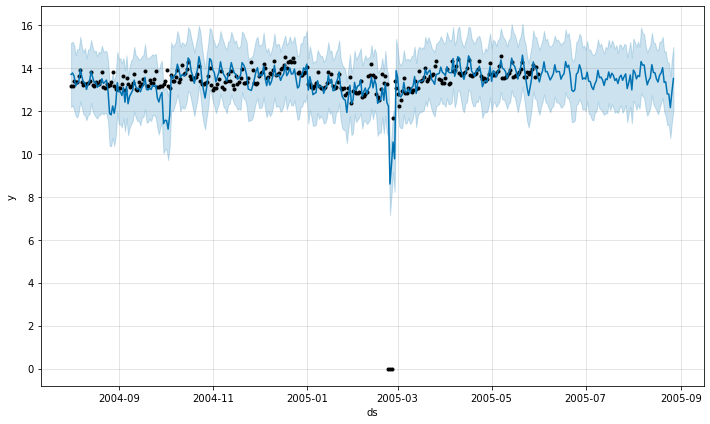

In [96]:
future = df_state.drop(columns = 'y')
forecast = m.predict(future)
fig1 = m.plot(forecast)

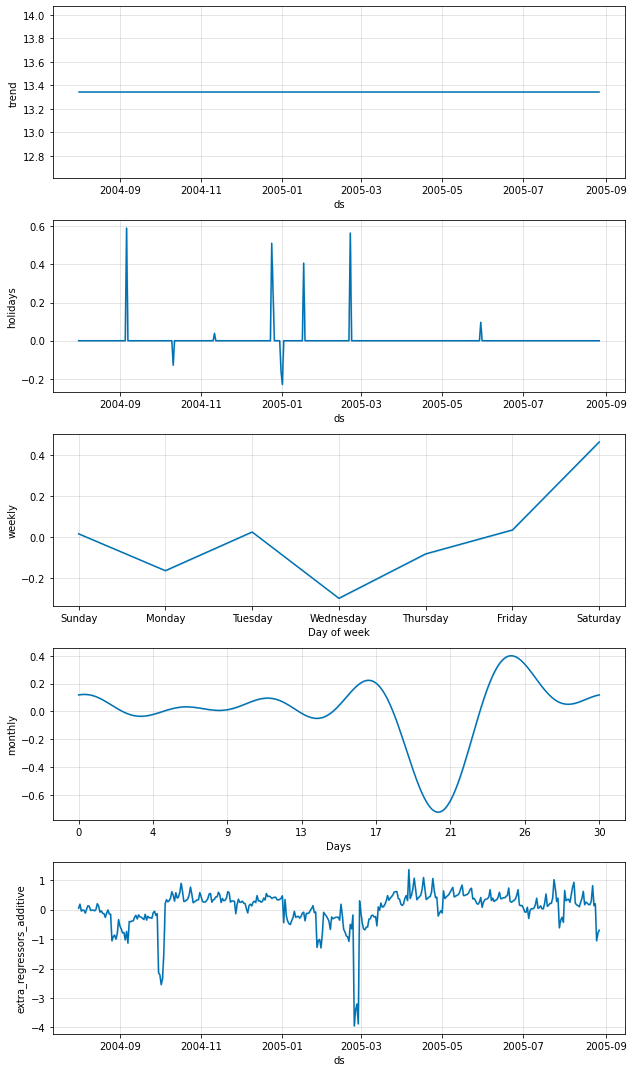

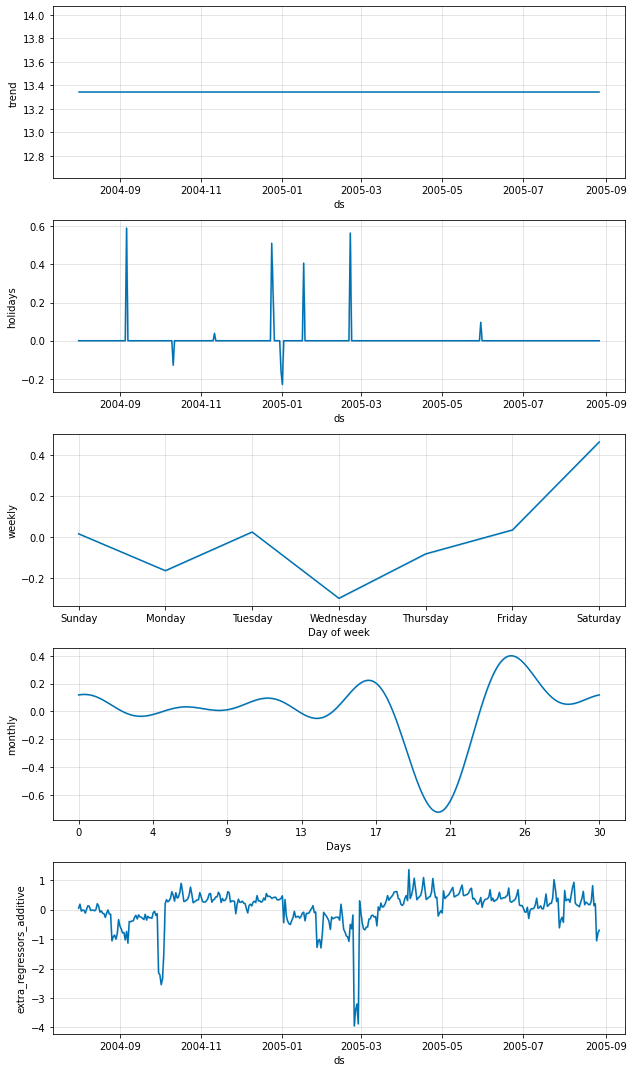

In [97]:
fig = m.plot_components(forecast)
fig

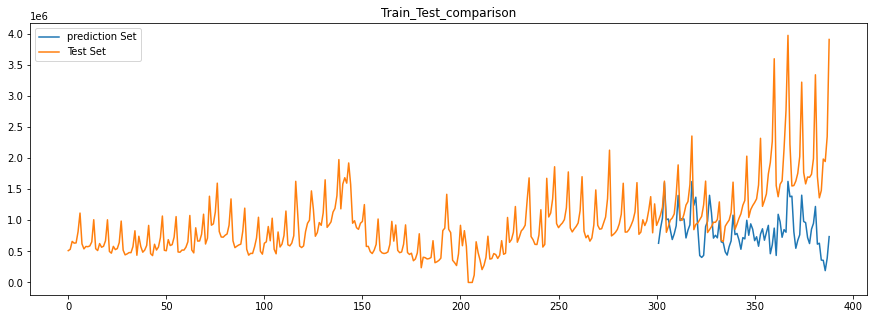

In [98]:
# graph the distribution of prediction vs actual
test_ts_draw = df_result['y']
test_prediction = df_result[df_result['ds']>='2005-06-01']['yhat']
fig, ax = plt.subplots(figsize=(15, 5))
test_prediction.plot(ax=ax, label='prediction Set', title='Train_Test_comparison')
test_ts_draw.plot(ax=ax, label='Test Set')
ax.legend(['prediction Set', 'Test Set'])
plt.show()

In [99]:
df_result[df_result['ds']>='2005-06-01']

,ds,yhat,y
301,2005-06-01,6.295415e+05,993452.0
302,2005-06-02,8.658083e+05,1084340.0
303,2005-06-03,1.034303e+06,1208760.0
304,2005-06-04,1.603489e+06,1627830.0
305,2005-06-05,1.009341e+06,805507.0
...,...,...,...
384,2005-08-23,3.591635e+05,1477840.0
385,2005-08-24,3.554261e+05,1982620.0
386,2005-08-25,1.898975e+05,1943150.0
387,2005-08-26,3.904251e+05,2344460.0


In [100]:
def show_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [101]:
show_results(df_result[df_result['ds']>='2005-06-01']['y'],df_result[df_result['ds']>='2005-06-01']['yhat'])

explained_variance:  0.0063
r2:  -0.9998
MAE:  729100.3736
MSE:  920612007297.7316
RMSE:  959485.2825
